In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict
from pptoolbox.platform.automl_v4.loss_functions import *
from pptoolbox.platform.automl_v4.stop_functions import stopping_criteria

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

from skmultilearn.model_selection import iterative_train_test_split

import warnings
warnings.simplefilter("ignore")

import pickle as pkl
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# MLFLOW_TRACKING_URI = "http://127.0.0.1:8080" # "sqlite:///mlflow.db"

# import data

In [2]:
datasets = {
    'full': {},
    'nondeo': {}
}

pulldate = "250218"

In [3]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')

    save_dir = f"../data/processed/{dataset}"

    X_train = pd.read_csv(f'{save_dir}/Xtrain.csv', index_col=0)
    X_test = pd.read_csv(f'{save_dir}/Xtest.csv', index_col=0)
    y_train = pd.read_csv(f'{save_dir}/ytrain.csv', index_col=0)
    y_test = pd.read_csv(f'{save_dir}/ytest.csv', index_col=0)

    datasets[dataset]['X_train'] = X_train
    datasets[dataset]['X_test'] = X_test
    datasets[dataset]['y_train'] = y_train
    datasets[dataset]['y_test'] = y_test

    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
    print()

Processing full dataset
X_train: (3024, 191), y_train: (3024, 20)
X_test: (763, 191), y_test: (763, 20)

Processing nondeo dataset
X_train: (2004, 191), y_train: (2004, 19)
X_test: (545, 191), y_test: (545, 19)



# Classify

In [13]:
for dataset in datasets:

    # if dataset !="nondeo":
    #     continue

    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    for i, col in enumerate(y_train.select_dtypes(include=['object']).columns):
        # if i>0:
        #     continue

        print(f'Training model for {col}')
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_train = y_train[col]

        #check if encoder exists
        if (output_dir / "encoder.pkl").exists():
            encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
            selected_y_train_encoded = pd.Series(
                encoder.transform(selected_y_train),
                index = selected_y_train.index
            )
        else:
            encoder = LabelEncoder()
            selected_y_train_encoded = pd.Series(
                encoder.fit_transform(selected_y_train),
                index = selected_y_train.index
            )

            pkl.dump(encoder, open(output_dir / "encoder.pkl", "wb"))

        # check if model exists
        if (output_dir / "trainer.pkl").exists():
            print("Model exists, skipping training")
        else:
            trainer = AutoML_v4(
                task_type = "classify", 
                loss_fn = add_timeout(loss_function, timeout = 30),
                stop_fn = stopping_criteria,
                exploration = 50,
                exploitation = 150,
                stagnant_runs = 50,
                # log=True
            )
            # trainer.set_log_config(experiment_name = f"{dataset}_{col}_og")
            trainer.fit(X_train, selected_y_train_encoded)
            pkl.dump(trainer, open(
                output_dir / "trainer.pkl", "wb"
            ))
            pkl.dump(trainer.get_pipeline(), open(
                output_dir / "origin_model_prediction.pkl", "wb"
            ))

Processing full dataset
Training model for Acetic
Model exists, skipping training
Training model for Ash
Model exists, skipping training
Training model for Astringent
Model exists, skipping training
Training model for Bitter
Model exists, skipping training
Training model for Brown Fruit
Model exists, skipping training
Training model for Cacao (Chocolate)
Model exists, skipping training
Training model for Carbon
Model exists, skipping training
Training model for Deodorization Level
Model exists, skipping training
Training model for Earthy
Model exists, skipping training
Training model for Fishy
Model exists, skipping training
Training model for Heated Fat (Oil)
Model exists, skipping training
Training model for Musty
Model exists, skipping training
Training model for Oxidized (Old Butter-Stale-Cardboard)
Model exists, skipping training
Training model for Painty (Solvent-Chemical)
Model exists, skipping training
Training model for Petroleum (Motor Oil-Rubber)
Model exists, skipping train

In [14]:
# inspect trainer
for dataset in datasets:
    print(f'Loading {dataset} trainer')
    for col in datasets[dataset]['y_train'].columns:
        if datasets[dataset]['y_train'][col].dtype == 'float64':
            # print(f'{col} is a float64 column, skipping')
            continue
        print(f'Inspecting model for {col}')
        
        add_timeout(loss_function,30)
        stopping_criteria(None)
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
        display(trainer.get_pipeline()
    )
    print()

Loading full trainer
Inspecting model for Acetic


Pipeline(steps=[('SG1D5W', SavitzkyGolay(deriv=1, window=5)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=8, random_state=42)),
                ('KNN', KNeighborsClassifier(n_neighbors=9, p=4))])

Inspecting model for Ash


Pipeline(steps=[('SNV-SG1D15W', SNV_SGD(deriv=1, window=15)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=26, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Astringent


Pipeline(steps=[('SNV-SG2D11W', SNV_SGD(deriv=2, window=11)),
                ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Bitter


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=30, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Brown Fruit


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=31, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Cacao (Chocolate)


Pipeline(steps=[('SG2D21W', SavitzkyGolay(deriv=2, window=21)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=24, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Carbon


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('SVC',
                 SVC(C=0.422627092697318, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Deodorization Level


Pipeline(steps=[('SG1D19W', SavitzkyGolay(deriv=1, window=19)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=21, random_state=42)),
                ('SVC',
                 SVC(C=2.571938917402374, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Earthy


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Fishy


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=31, random_state=42)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Heated Fat (Oil)


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=14, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Musty


Pipeline(steps=[('SNV-SG2D7W', SNV_SGD(deriv=2, window=7)),
                ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Oxidized (Old Butter-Stale-Cardboard)


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('SVC',
                 SVC(C=440.149427819786, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Painty (Solvent-Chemical)


Pipeline(steps=[('SNV-SG2D21W', SNV_SGD(deriv=2, window=21)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=21, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Petroleum (Motor Oil-Rubber)


Pipeline(steps=[('SNV-SG1D7W', SNV_SGD(deriv=1, window=7)),
                ('Scaler', StandardScaler(with_std=False)),
                ('SVC',
                 SVC(C=29.626456558311236, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Putrid


Pipeline(steps=[('SNV-SG2D9W', SNV_SGD(deriv=2, window=9)),
                ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Smoky


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Sour


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=29, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Straw (Hay)


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=30, random_state=42)),
                ('LDA', LinearDiscriminantAnalysis())])


Loading nondeo trainer
Inspecting model for Acetic


Pipeline(steps=[('SNV-SG1D19W', SNV_SGD(deriv=1, window=19)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=32, random_state=42)),
                ('LDA', LinearDiscriminantAnalysis())])

Inspecting model for Ash


Pipeline(steps=[('SNV-SG2D5W', SNV_SGD(deriv=2, window=5)),
                ('Scaler', StandardScaler(with_std=False)),
                ('SVC',
                 SVC(C=64.97100786925728, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Astringent


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=30, random_state=42)),
                ('KNN', KNeighborsClassifier(p=5))])

Inspecting model for Bitter


Pipeline(steps=[('SG1D13W', SavitzkyGolay(deriv=1, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=16, random_state=42)),
                ('SVC',
                 SVC(C=0.27816307898793, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Brown Fruit


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=30, random_state=42)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Cacao (Chocolate)


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('SVC',
                 SVC(C=10.434163445222598, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Carbon


Pipeline(steps=[('SNV-SG1D21W', SNV_SGD(deriv=1, window=21)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=30, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Earthy


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=22, random_state=42)),
                ('SVC',
                 SVC(C=5.319236201017696, cache_size=2000, probability=True,
                     random_state=42))])

Inspecting model for Fishy


Pipeline(steps=[('SNV-SG2D19W', SNV_SGD(deriv=2, window=19)),
                ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Heated Fat (Oil)


Pipeline(steps=[('SNV-SG2D7W', SNV_SGD(deriv=2, window=7)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=30, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Musty


Pipeline(steps=[('SG2D13W', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Oxidized (Old Butter-Stale-Cardboard)


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=31, random_state=42)),
                ('KNN', KNeighborsClassifier(n_neighbors=7, p=6))])

Inspecting model for Painty (Solvent-Chemical)


Pipeline(steps=[('SG2D11W', SavitzkyGolay(deriv=2, window=11)),
                ('Scaler', StandardScaler(with_std=False)),
                ('GaussianNB', GaussianNB())])

Inspecting model for Petroleum (Motor Oil-Rubber)


Pipeline(steps=[('Detrend', Detrend()),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=17, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Putrid


Pipeline(steps=[('SNV', SNV()), ('Scaler', StandardScaler(with_std=False)),
                ('KNN', KNeighborsClassifier(n_neighbors=3, p=1))])

Inspecting model for Smoky


Pipeline(steps=[('SNV-SG1D17W', SNV_SGD(deriv=1, window=17)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=17, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

Inspecting model for Sour


Pipeline(steps=[('SG2D5W', SavitzkyGolay(deriv=2, window=5)),
                ('Scaler', StandardScaler(with_std=False)),
                ('SVC',
                 SVC(C=20.420091571401567, cache_size=2000, kernel='linear',
                     probability=True, random_state=42))])

Inspecting model for Straw (Hay)


Pipeline(steps=[('SG1D9W', SavitzkyGolay(deriv=1, window=9)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=24, random_state=42)),
                ('KNN', KNeighborsClassifier(n_neighbors=7, p=6))])

# Classify Downsampled

In [ ]:
# datasets = {
#     'full': {},
#     # 'deo': {},
#     'nondeo': {}
# }

In [ ]:
# for dataset in datasets:

#     print(f'Processing {dataset} dataset')

#     save_dir = f"../data/processed/{dataset}"

#     X_train_downsampled = pd.read_csv(f'{save_dir}/Xtrain_downsampled.csv', index_col=0)
#     X_test = pd.read_csv(f'{save_dir}/Xtest.csv', index_col=0)
#     y_train_downsampled = pd.read_csv(f'{save_dir}/ytrain_downsampled.csv', index_col=0)
#     y_test = pd.read_csv(f'{save_dir}/ytest.csv', index_col=0)

#     datasets[dataset]['X_train_downsampled'] = X_train_downsampled
#     datasets[dataset]['X_test'] = X_test
#     datasets[dataset]['y_train_downsampled'] = y_train_downsampled
#     datasets[dataset]['y_test'] = y_test

#     print(f'X_train_downsampled: {X_train_downsampled.shape}, y_train_downsampled: {y_train_downsampled.shape}')
#     print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
#     print()

In [ ]:
# for dataset in datasets:

#     print(f'Processing {dataset} dataset')
#     X_train = datasets[dataset]['X_train_downsampled']
#     y_train = datasets[dataset]['y_train_downsampled']

#     for i, col in enumerate(y_train.select_dtypes(include=['object']).columns):

#         print(f'Training model for {col}')
        
#         output_dir = Path(f"../models/automl/{dataset}_downsampled/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_train = y_train[col]

#         #check if encoder exists
#         if (output_dir / "encoder.pkl").exists():
#             encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
#             selected_y_train_encoded = pd.Series(
#                 encoder.transform(selected_y_train),
#                 index = selected_y_train.index
#             )
#         else:
#             encoder = LabelEncoder()
#             selected_y_train_encoded = pd.Series(
#                 encoder.fit_transform(selected_y_train),
#                 index = selected_y_train.index
#             )

#             pkl.dump(encoder, open(output_dir / "encoder.pkl", "wb"))

#         # check if model exists
#         if (output_dir / "trainer.pkl").exists():
#             print("Model exists, skipping training")
#         else:
#             trainer = AutoML_v4(
#                 task_type = "classify", 
#                 loss_fn = add_timeout(loss_function, timeout = 30),
#                 stop_fn = stopping_criteria,
#                 exploration = 50,
#                 exploitation = 150,
#                 stagnant_runs = 50,
#                 # log=True
#             )
#             # trainer.set_log_config(experiment_name = f"{dataset}_{col}_downsample")
#             trainer.fit(X_train, selected_y_train_encoded)
#             pkl.dump(trainer, open(
#                 output_dir / "trainer.pkl", "wb"
#     ))

# cross val predict

fixed cross_group_predict function

## summarised cfm

Processing full dataset
Getting CV scores for Acetic
Getting CV scores for Ash
Getting CV scores for Astringent
Getting CV scores for Bitter
Getting CV scores for Brown Fruit
Getting CV scores for Cacao (Chocolate)
Getting CV scores for Carbon
Getting CV scores for Deodorization Level
Getting CV scores for Earthy
Getting CV scores for Fishy
Getting CV scores for Heated Fat (Oil)
Getting CV scores for Musty
Getting CV scores for Oxidized (Old Butter-Stale-Cardboard)
Getting CV scores for Painty (Solvent-Chemical)
Getting CV scores for Petroleum (Motor Oil-Rubber)
Getting CV scores for Putrid
Getting CV scores for Smoky
Getting CV scores for Sour
Getting CV scores for Straw (Hay)


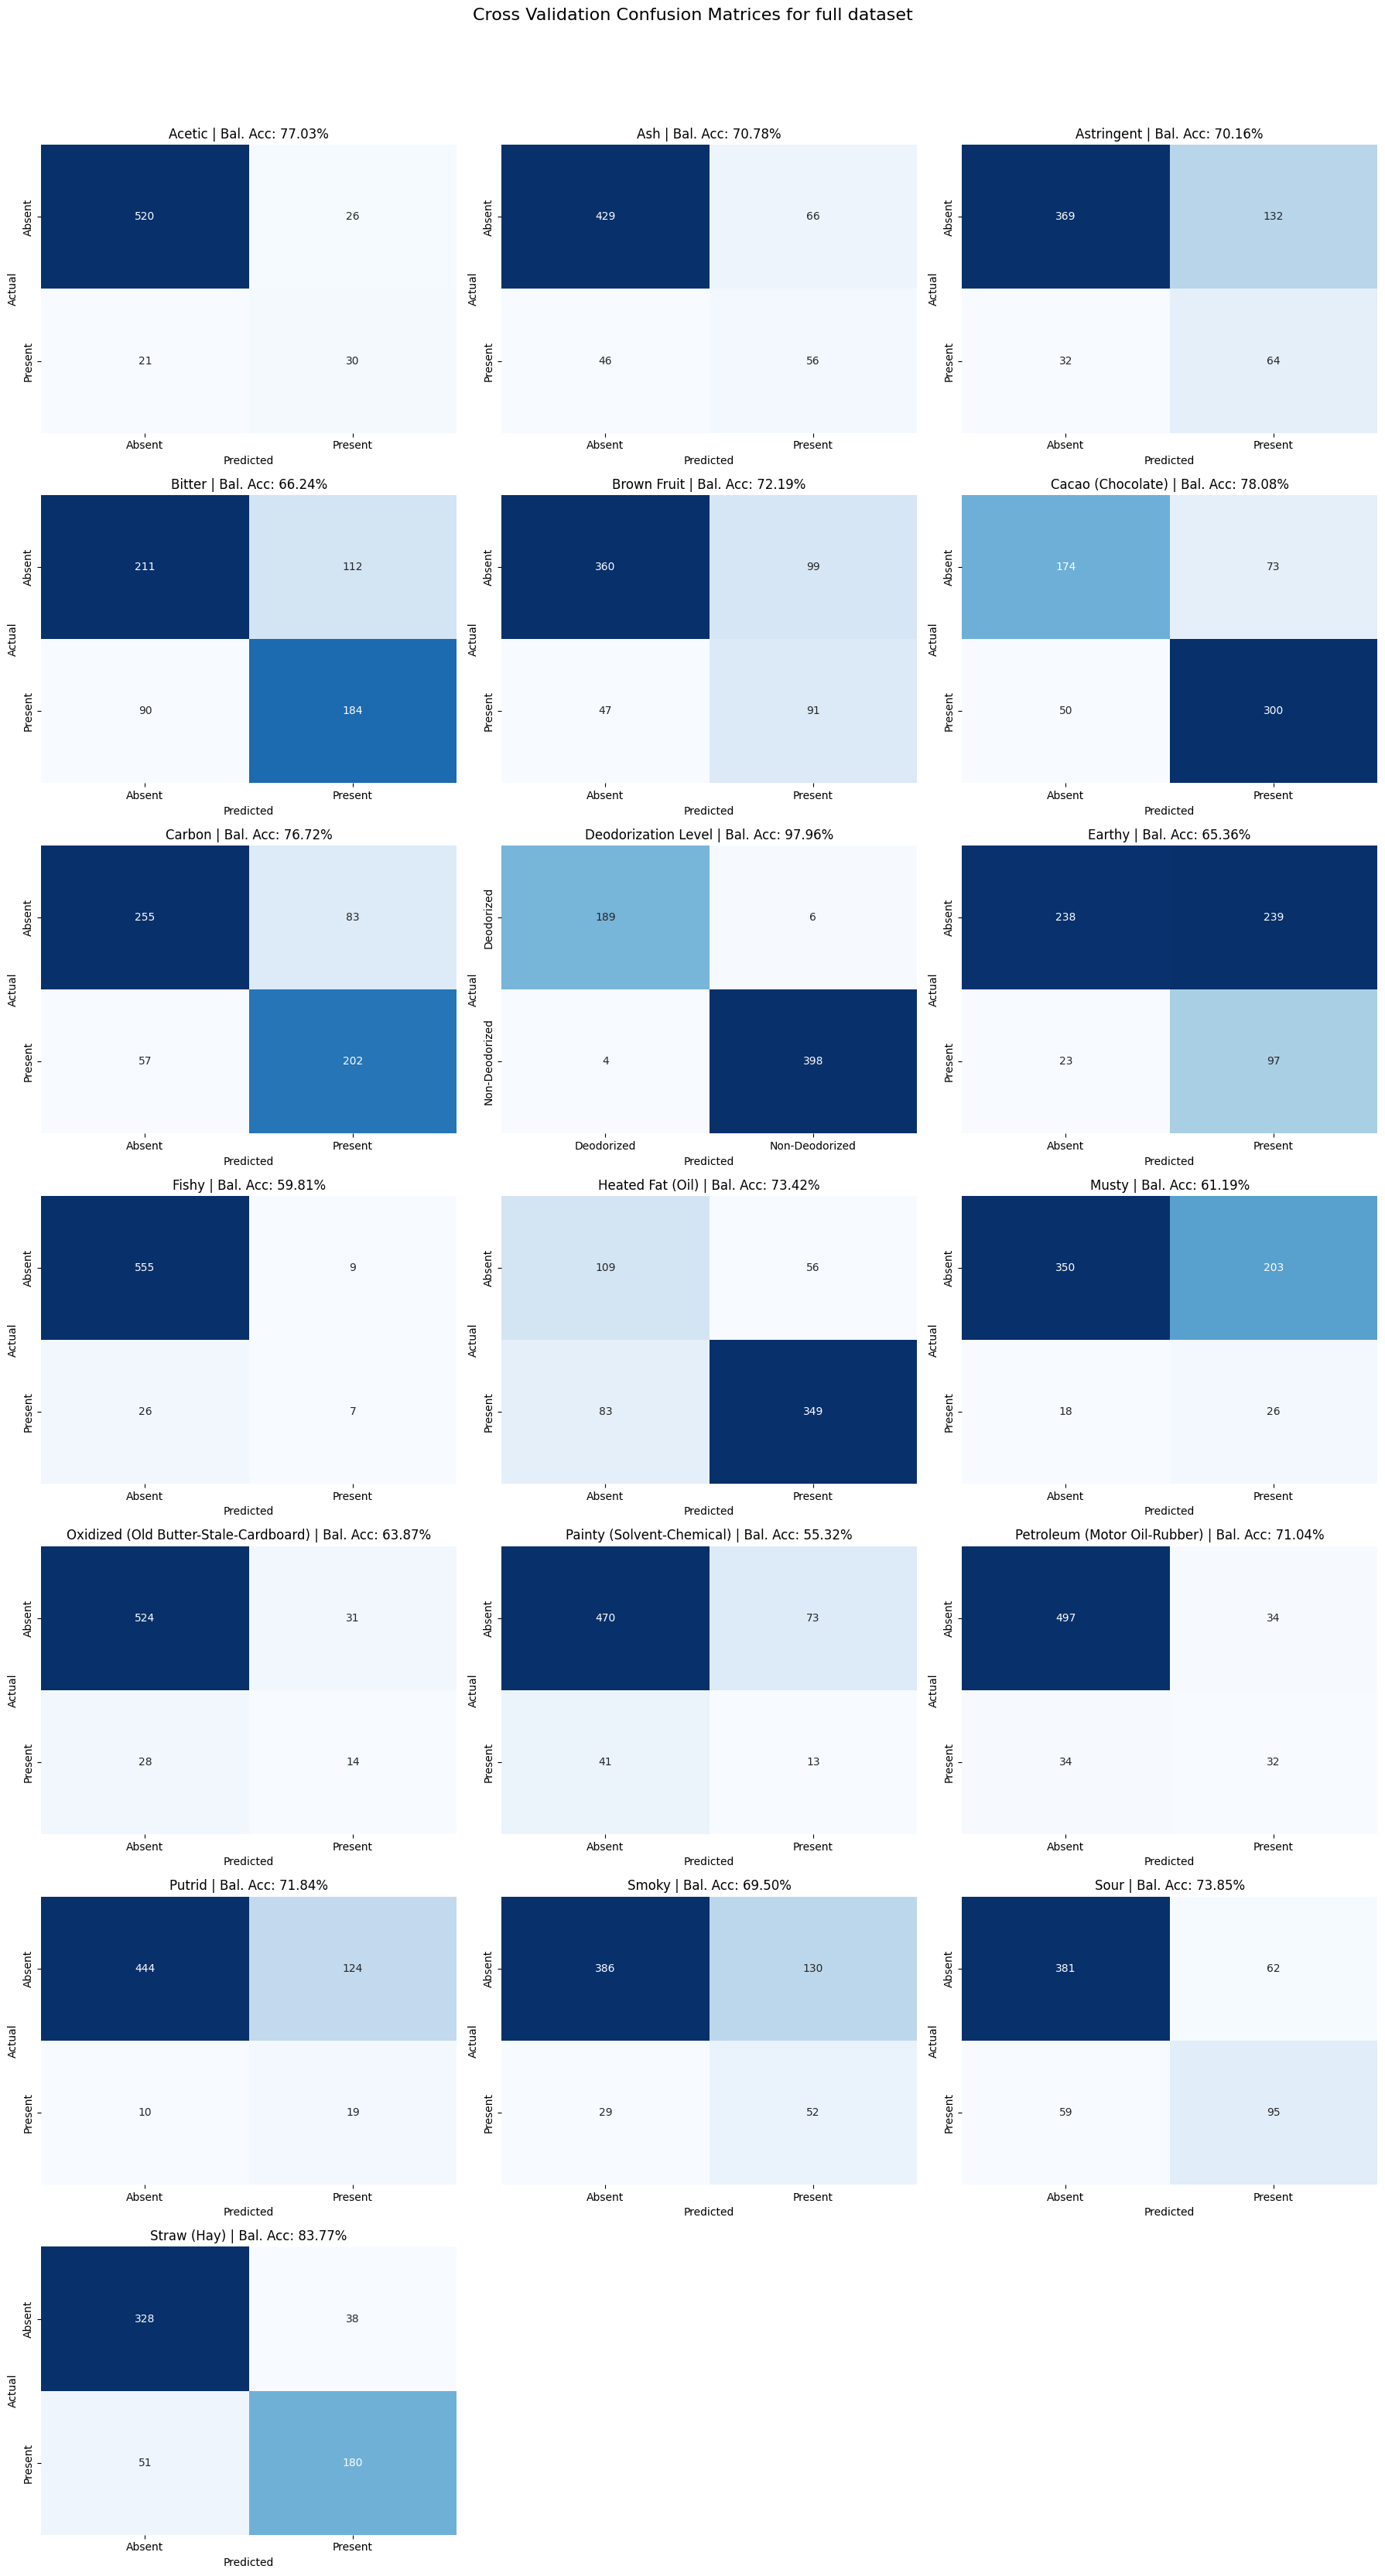

Processing nondeo dataset
Getting CV scores for Acetic
Getting CV scores for Ash
Getting CV scores for Astringent
Getting CV scores for Bitter
Getting CV scores for Brown Fruit
Getting CV scores for Cacao (Chocolate)
Getting CV scores for Carbon
Getting CV scores for Earthy
Getting CV scores for Fishy
Getting CV scores for Heated Fat (Oil)
Getting CV scores for Musty
Getting CV scores for Oxidized (Old Butter-Stale-Cardboard)
Getting CV scores for Painty (Solvent-Chemical)
Getting CV scores for Petroleum (Motor Oil-Rubber)
Getting CV scores for Putrid
Getting CV scores for Smoky
Getting CV scores for Sour
Getting CV scores for Straw (Hay)


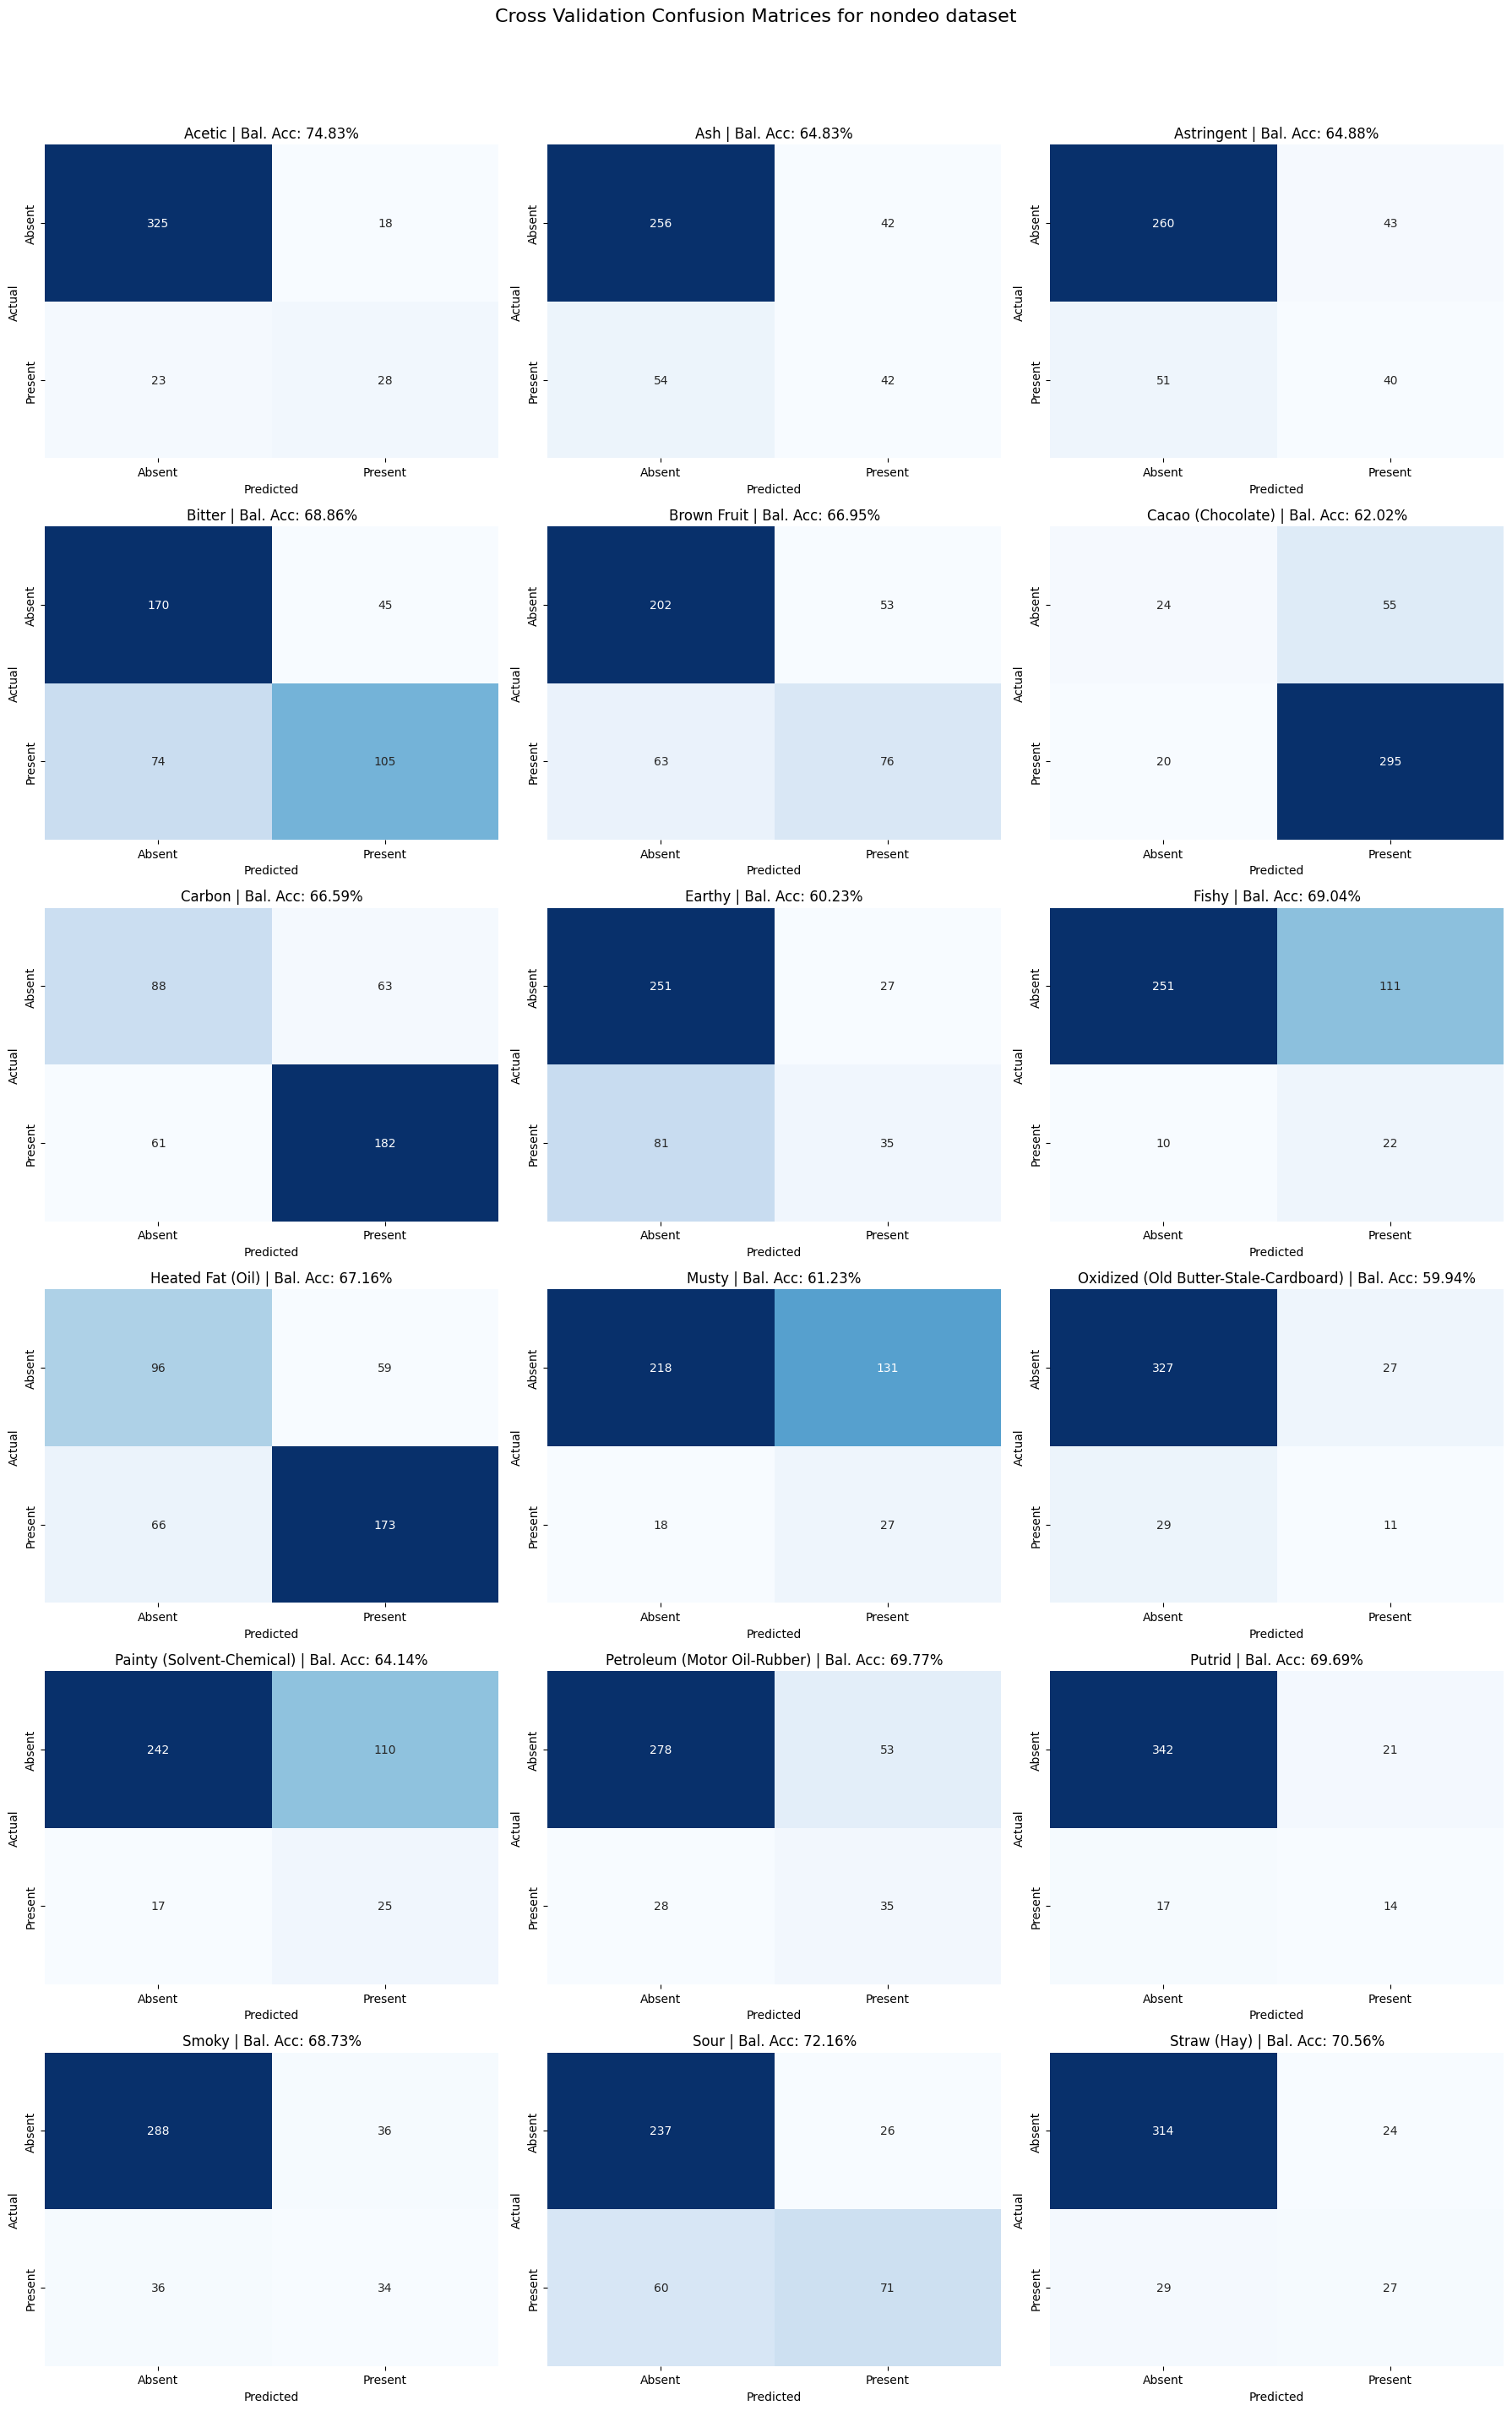

In [15]:
for dataset in datasets:

    # if dataset != "nondeo":
    #     continue

    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    # Count the number of categorical columns in y_train
    categorical_cols = [col for col in y_train.columns if y_train[col].dtype == 'object']
    num_cols = len(categorical_cols)

    # Set up subplot grid size dynamically
    ncols = min(3, num_cols)  # At most 3 columns per row
    nrows = int(np.ceil(num_cols / ncols))  # Compute the number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
    fig.suptitle(f"Cross Validation Confusion Matrices for {dataset} dataset", fontsize=16)

    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])  # Make it a 2D array for consistency
    elif nrows == 1:
        axes = np.array([axes])  # Convert 1D array to 2D
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])  # Convert to 2D array

    for idx, col in enumerate(categorical_cols):

        # if idx>0:
        #     continue

        print(f'Getting CV scores for {col}')
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_train = y_train[col]

        # Check if encoder exists
        encoder_path = output_dir / "encoder.pkl"
        if encoder_path.exists():
            encoder = pkl.load(open(encoder_path, "rb"))
            selected_y_train_encoded = pd.Series(
                encoder.transform(selected_y_train),
                index=selected_y_train.index
            )
        else:
            print("Encoder does not exist, skipping cv")
            continue

        # Check if model exists
        model_path = output_dir / "trainer.pkl"
        if model_path.exists():
            add_timeout(loss_function,30)
            stopping_criteria(None)
            trainer = pkl.load(open(model_path, "rb"))
        else:
            print("Model does not exist, skipping cv")
            continue

        grouped_X = X_train.groupby(X_train.index).mean()
        grouped_y = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

        # Calculate CV confusion matrix
        kfold = StratifiedGroupKFold(n_splits=3)

        grouped_cv_pred = cross_group_predict(
            trainer.get_pipeline(),
            X=X_train,
            y=selected_y_train_encoded,
            cv=kfold,
            groups=X_train.index
        )

        cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
        bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

        # Get subplot axes
        ax = axes[idx // ncols, idx % ncols]

        ax.set_title(f"{col} | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)

        cnfm_settings = {
            "cmap": "Blues",
            "cbar": False,
            "annot": True,
            "fmt": ".0f",
            "xticklabels": encoder.classes_,
            "yticklabels": encoder.classes_,
        }

        sns.heatmap(cnfm, ax=ax, **cnfm_settings)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide any empty subplots
    for idx in range(num_cols, nrows * ncols):  # Only affects extra subplots
        fig.delaxes(axes.flatten()[idx])  # Remove empty subplot

    # Adjust layout and save the combined figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"../models/automl/{dataset}/cv_metrics_summary.png",bbox_inches = "tight")
    plt.show()
    plt.close()

## summarised cfm downsample

Processing full dataset
Getting CV scores for Acetic
Getting CV scores for Ash
Getting CV scores for Astringent
Getting CV scores for Bitter
Getting CV scores for Brown Fruit
Getting CV scores for Cacao (Chocolate)
Getting CV scores for Carbon
Getting CV scores for Deodorization Level
Getting CV scores for Earthy
Getting CV scores for Fishy
Getting CV scores for Heated Fat (Oil)
Getting CV scores for Musty
Getting CV scores for Oxidized (Old Butter-Stale-Cardboard)
Getting CV scores for Painty (Solvent-Chemical)
Getting CV scores for Petroleum (Motor Oil-Rubber)
Getting CV scores for Putrid
Getting CV scores for Smoky
Getting CV scores for Sour
Getting CV scores for Straw (Hay)


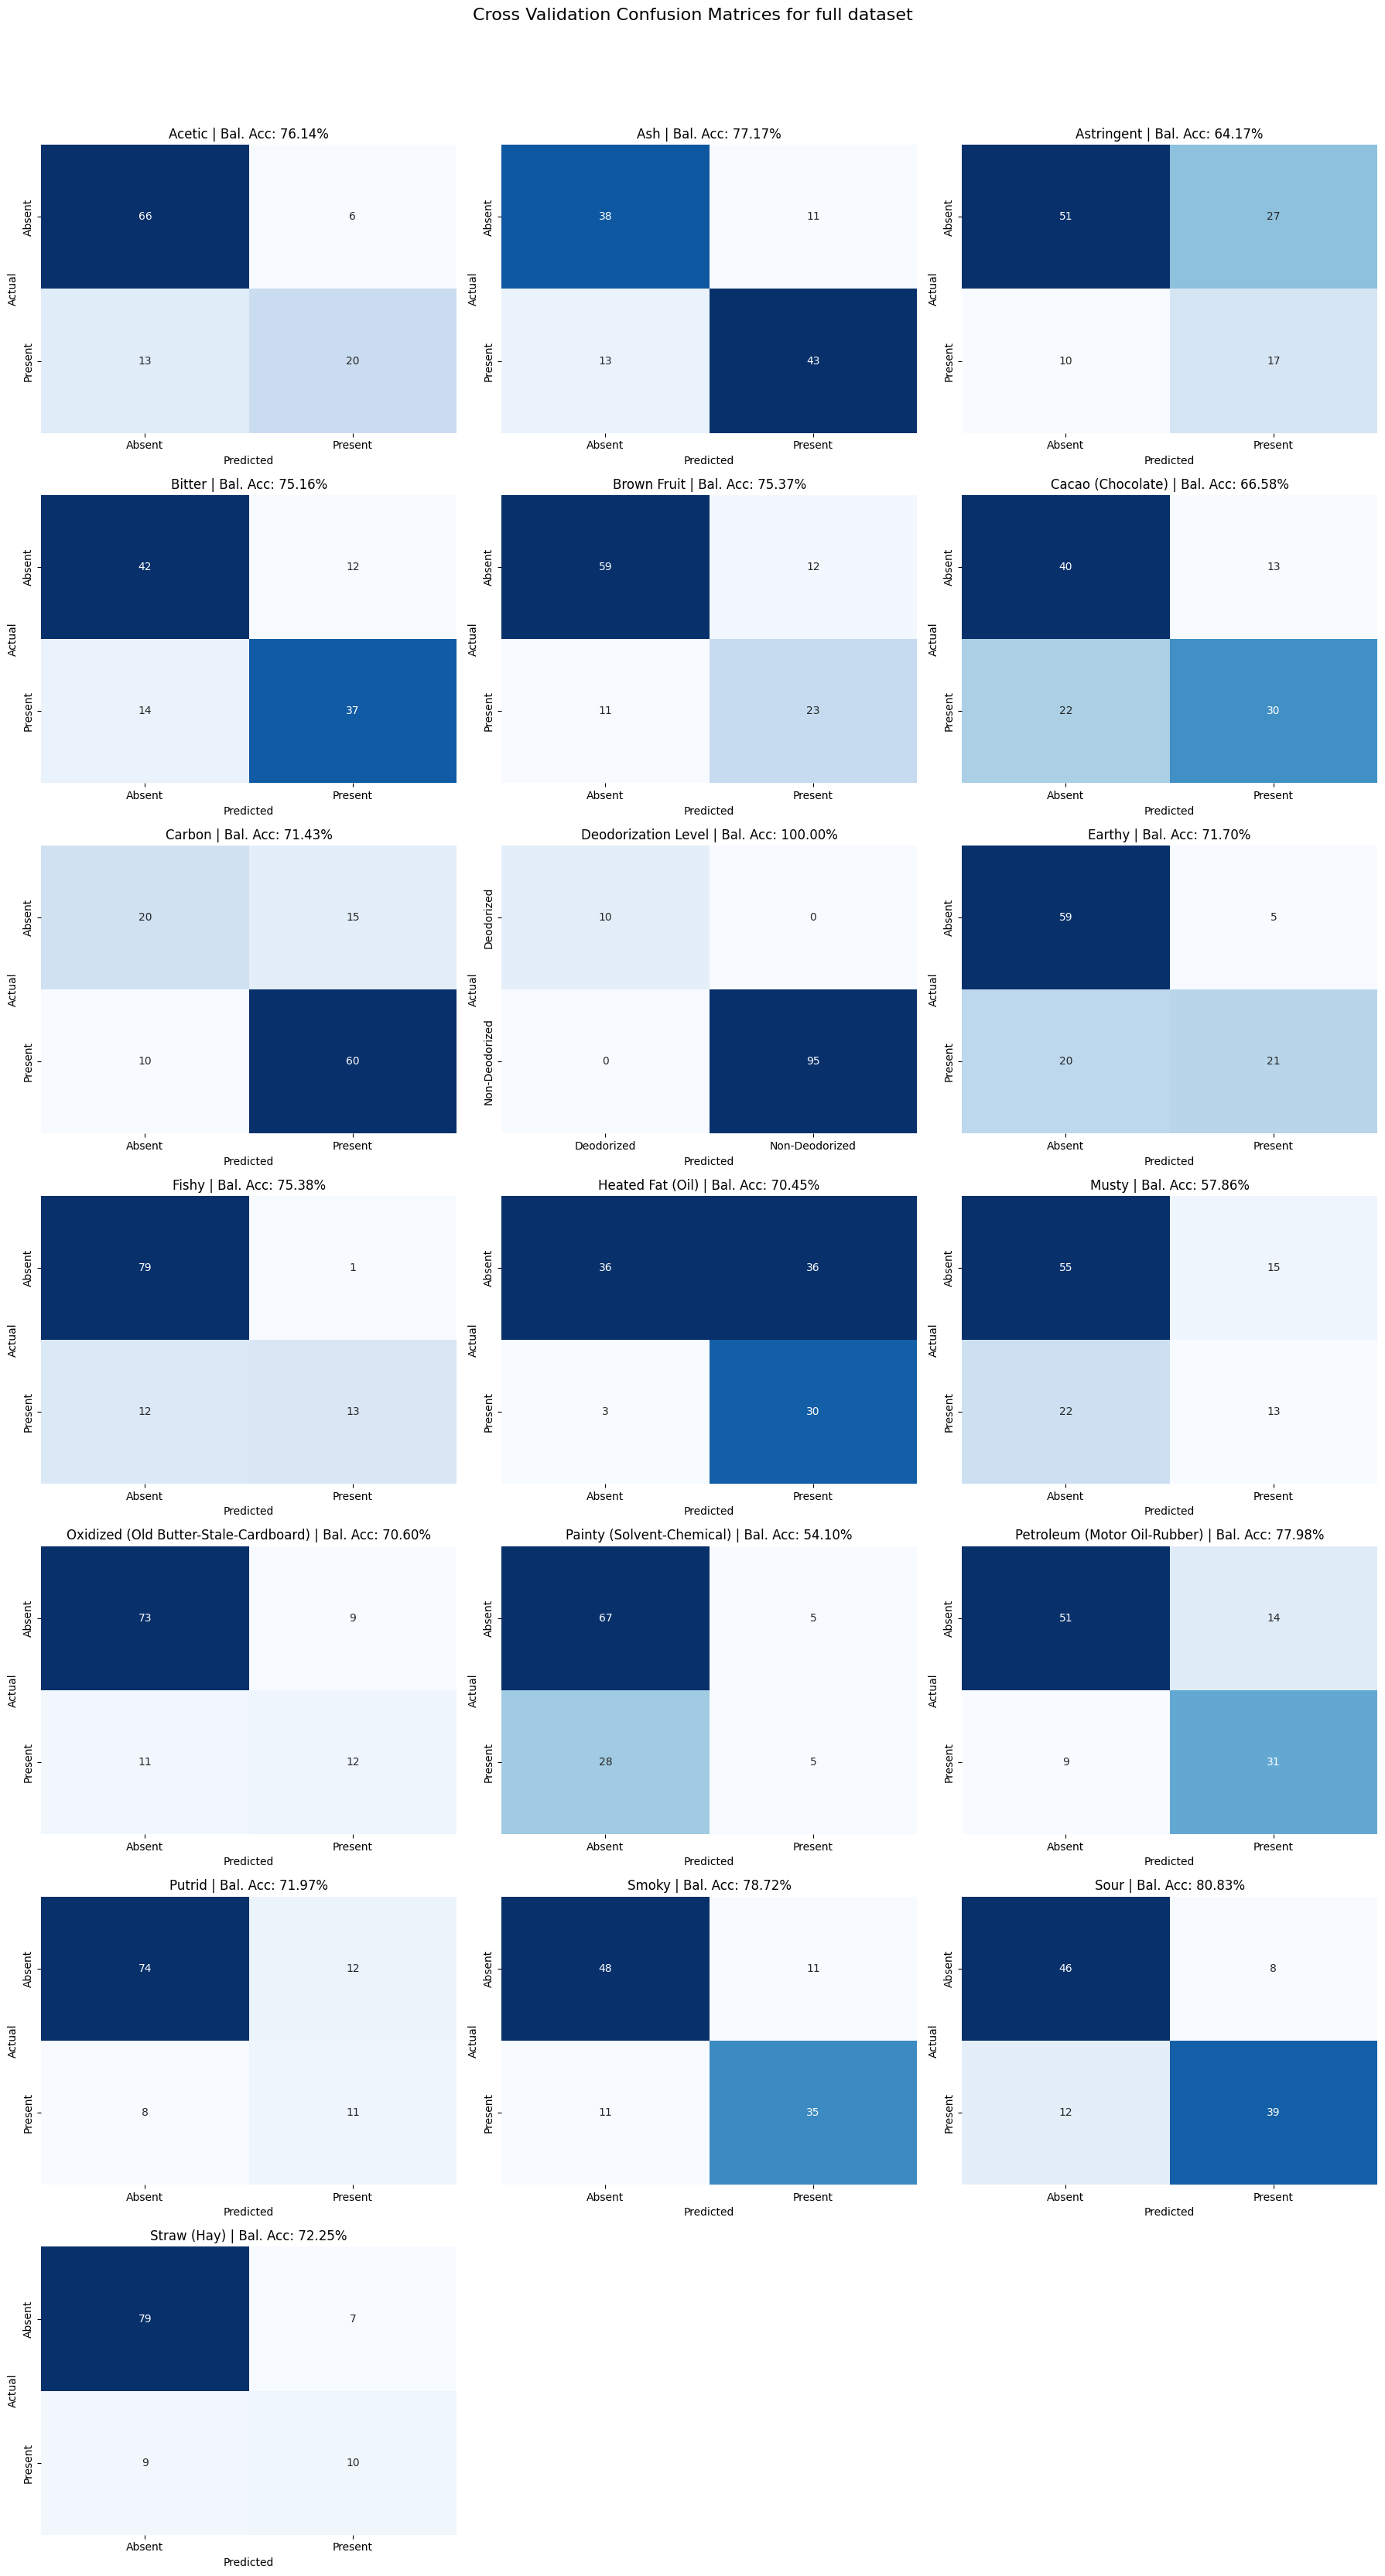

Processing nondeo dataset
Getting CV scores for Acetic
Getting CV scores for Ash
Getting CV scores for Astringent
Getting CV scores for Bitter
Getting CV scores for Brown Fruit
Getting CV scores for Cacao (Chocolate)
Getting CV scores for Carbon
Getting CV scores for Earthy
Getting CV scores for Fishy
Getting CV scores for Heated Fat (Oil)
Getting CV scores for Musty
Getting CV scores for Oxidized (Old Butter-Stale-Cardboard)
Getting CV scores for Painty (Solvent-Chemical)
Getting CV scores for Petroleum (Motor Oil-Rubber)
Getting CV scores for Putrid
Getting CV scores for Smoky
Getting CV scores for Sour
Getting CV scores for Straw (Hay)


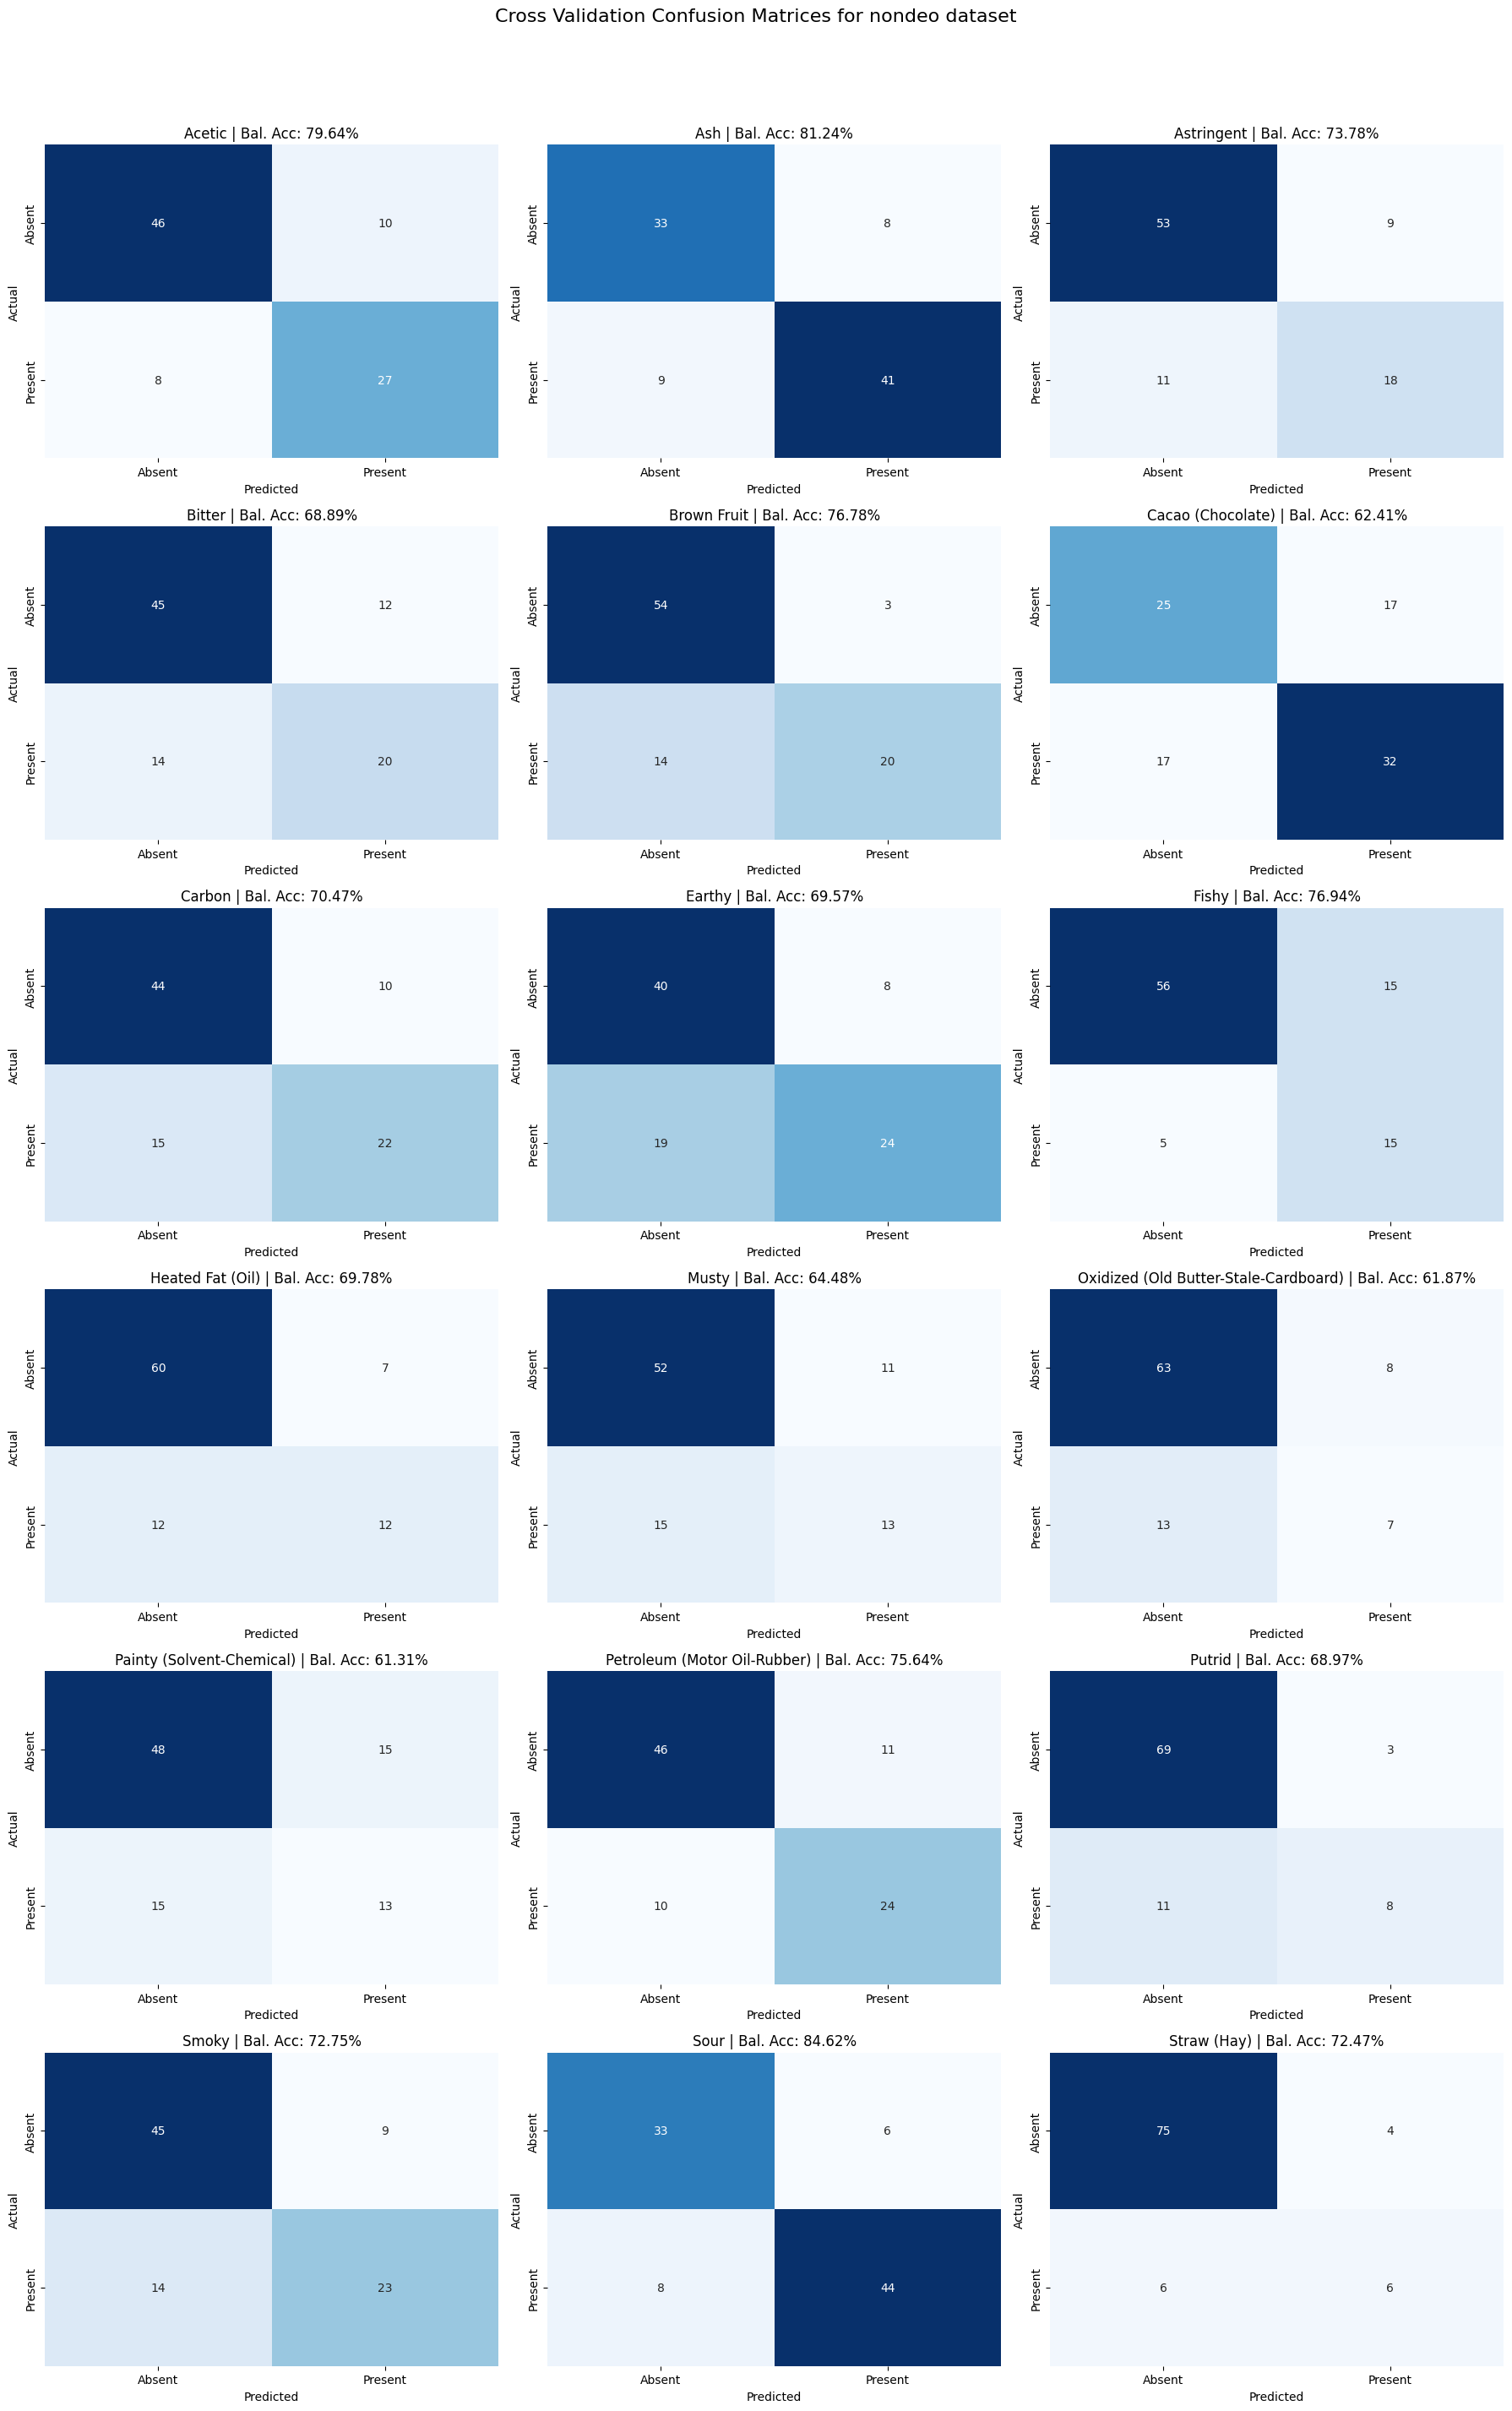

In [ ]:
# for dataset in datasets:

#     print(f'Processing {dataset} dataset')
#     X_train = datasets[dataset]['X_train_downsampled']
#     y_train = datasets[dataset]['y_train_downsampled']

#     # Count the number of categorical columns in y_train
#     categorical_cols = [col for col in y_train.columns if y_train[col].dtype == 'object']
#     num_cols = len(categorical_cols)

#     # Set up subplot grid size dynamically
#     ncols = min(3, num_cols)  # At most 3 columns per row
#     nrows = int(np.ceil(num_cols / ncols))  # Compute the number of rows

#     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
#     fig.suptitle(f"Cross Validation Confusion Matrices for {dataset} dataset", fontsize=16)

#     if nrows == 1 and ncols == 1:
#         axes = np.array([[axes]])  # Make it a 2D array for consistency
#     elif nrows == 1:
#         axes = np.array([axes])  # Convert 1D array to 2D
#     elif ncols == 1:
#         axes = np.array([[ax] for ax in axes])  # Convert to 2D array

#     for idx, col in enumerate(categorical_cols):

#         print(f'Getting CV scores for {col}')
        
#         output_dir = Path(f"../models/automl/{dataset}_downsampled/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_train = y_train[col]

#         # Check if encoder exists
#         encoder_path = output_dir / "encoder.pkl"
#         if encoder_path.exists():
#             encoder = pkl.load(open(encoder_path, "rb"))
#             selected_y_train_encoded = pd.Series(
#                 encoder.transform(selected_y_train),
#                 index=selected_y_train.index
#             )
#         else:
#             print("Encoder does not exist, skipping cv")
#             continue

#         # Check if model exists
#         model_path = output_dir / "trainer.pkl"
#         if model_path.exists():
#             trainer = pkl.load(open(model_path, "rb"))
#         else:
#             print("Model does not exist, skipping cv")
#             continue

#         grouped_X = X_train.groupby(X_train.index).mean()
#         grouped_y = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

#         # Calculate CV confusion matrix
#         kfold = StratifiedGroupKFold(n_splits=3)

#         grouped_cv_pred = cross_group_predict(
#             trainer.get_pipeline(),
#             X=X_train,
#             y=selected_y_train_encoded,
#             cv=kfold,
#             groups=X_train.index
#         )

#         # continue

#         cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
#         bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

#         # Get subplot axes
#         ax = axes[idx // ncols, idx % ncols]

#         ax.set_title(f"{col} | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)

#         cnfm_settings = {
#             "cmap": "Blues",
#             "cbar": False,
#             "annot": True,
#             "fmt": ".0f",
#             "xticklabels": encoder.classes_,
#             "yticklabels": encoder.classes_,
#         }

#         sns.heatmap(cnfm, ax=ax, **cnfm_settings)
#         ax.set_xlabel("Predicted")
#         ax.set_ylabel("Actual")

#     # Hide any empty subplots
#     for idx in range(num_cols, nrows * ncols):  # Only affects extra subplots
#         fig.delaxes(axes.flatten()[idx])  # Remove empty subplot

#     # Adjust layout and save the combined figure
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(f"../models/automl/{dataset}_downsampled/cv_metrics_summary.png",bbox_inches = "tight")
#     plt.show()
#     plt.close()

## individual cfm

In [9]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    for col in y_train.columns:
        if y_train[col].dtype != 'object':
            continue
        print(f'Getting cv scores for {col}')
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_train = y_train[col]

        #check if encoder exists
        if (output_dir / "encoder.pkl").exists():
            encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
            selected_y_train_encoded = pd.Series(
                encoder.transform(selected_y_train),
                index = selected_y_train.index
            )
        else:
            print("Encoder does not exist, skipping cv")

        # check if model exists
        if (output_dir / "trainer.pkl").exists():
            trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
        else:
            print("Model does not exist, skipping cv")

        grouped_X = X_train.groupby(X_train.index).mean()
        grouped_y = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

        # Calculate CV confusion matrix
        kfold = StratifiedGroupKFold(n_splits = 3)

        grouped_cv_pred = cross_group_predict(
            trainer.get_pipeline(), 
            X = X_train,
            y = selected_y_train_encoded,
            cv = kfold,
            groups = X_train.index
        )

        cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
        bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

        fig = plt.figure(figsize = (6, 4))
        fig.suptitle(f"{col} | Cross Validation")
        ax = fig.add_subplot(111)

        ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

        cnfm_settings = {
            "cmap": "Blues",
            "cbar": None,
            "annot": True,
            "fmt": ".0f",
            "xticklabels": encoder.classes_,
            "yticklabels": encoder.classes_,
        }

        sns.heatmap(
            cnfm,
            ax = ax,
            **cnfm_settings
        )

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        # plt.tight_layout()
        plt.savefig(output_dir / "cv_metrics.png", bbox_inches = "tight")
        # plt.show()
        plt.close()


Processing full dataset
Getting cv scores for Acetic
Getting cv scores for Ash
Getting cv scores for Astringent
Getting cv scores for Bitter
Getting cv scores for Brown Fruit
Getting cv scores for Cacao (Chocolate)
Getting cv scores for Carbon
Getting cv scores for Deodorization Level
Getting cv scores for Earthy
Getting cv scores for Fishy
Getting cv scores for Heated Fat (Oil)
Getting cv scores for Musty
Getting cv scores for Oxidized (Old Butter-Stale-Cardboard)
Getting cv scores for Painty (Solvent-Chemical)
Getting cv scores for Petroleum (Motor Oil-Rubber)
Getting cv scores for Putrid
Getting cv scores for Smoky
Getting cv scores for Sour
Getting cv scores for Straw (Hay)
Processing nondeo dataset
Getting cv scores for Acetic
Getting cv scores for Ash
Getting cv scores for Astringent
Getting cv scores for Bitter
Getting cv scores for Brown Fruit
Getting cv scores for Cacao (Chocolate)
Getting cv scores for Carbon
Getting cv scores for Earthy
Getting cv scores for Fishy
Getting cv

## individual cfm downsampled

In [ ]:
# for dataset in datasets:
#     print(f'Processing {dataset} dataset')
#     X_train = datasets[dataset]['X_train_downsampled']
#     y_train = datasets[dataset]['y_train_downsampled']

#     for col in y_train.columns:
#         if y_train[col].dtype != 'object':
#             continue
#         print(f'Getting cv scores for {col}')
        
#         output_dir = Path(f"../models/automl/{dataset}_downsampled/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_train = y_train[col]

#         #check if encoder exists
#         if (output_dir / "encoder.pkl").exists():
#             encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
#             selected_y_train_encoded = pd.Series(
#                 encoder.transform(selected_y_train),
#                 index = selected_y_train.index
#             )
#         else:
#             print("Encoder does not exist, skipping cv")

#         # check if model exists
#         if (output_dir / "trainer.pkl").exists():
#             trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
#         else:
#             print("Model does not exist, skipping cv")

#         grouped_X = X_train.groupby(X_train.index).mean()
#         grouped_y = selected_y_train_encoded.groupby(selected_y_train_encoded.index).mean()

#         # Calculate CV confusion matrix
#         kfold = StratifiedGroupKFold(n_splits = 3)

#         grouped_cv_pred = cross_group_predict(
#             trainer.get_pipeline(), 
#             X = X_train,
#             y = selected_y_train_encoded,
#             cv = kfold,
#             groups = X_train.index
#         )

#         cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
#         bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

#         fig = plt.figure(figsize = (6, 4))
#         fig.suptitle(f"{col} | Cross Validation")
#         ax = fig.add_subplot(111)

#         ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

#         cnfm_settings = {
#             "cmap": "Blues",
#             "cbar": None,
#             "annot": True,
#             "fmt": ".0f",
#             "xticklabels": encoder.classes_,
#             "yticklabels": encoder.classes_,
#         }

#         sns.heatmap(
#             cnfm,
#             ax = ax,
#             **cnfm_settings
#         )

#         ax.set_xlabel('Predicted')
#         ax.set_ylabel('Actual')

#         # plt.tight_layout()
#         plt.savefig(output_dir / "cv_metrics.png", bbox_inches = "tight")
#         # plt.show()
#         plt.close()


Processing full dataset
Getting cv scores for Acetic
Getting cv scores for Ash
Getting cv scores for Astringent
Getting cv scores for Bitter
Getting cv scores for Brown Fruit
Getting cv scores for Cacao (Chocolate)
Getting cv scores for Carbon
Getting cv scores for Deodorization Level
Getting cv scores for Earthy
Getting cv scores for Fishy
Getting cv scores for Heated Fat (Oil)
Getting cv scores for Musty
Getting cv scores for Oxidized (Old Butter-Stale-Cardboard)
Getting cv scores for Painty (Solvent-Chemical)
Getting cv scores for Petroleum (Motor Oil-Rubber)
Getting cv scores for Putrid
Getting cv scores for Smoky
Getting cv scores for Sour
Getting cv scores for Straw (Hay)
Processing nondeo dataset
Getting cv scores for Acetic
Getting cv scores for Ash
Getting cv scores for Astringent
Getting cv scores for Bitter
Getting cv scores for Brown Fruit
Getting cv scores for Cacao (Chocolate)
Getting cv scores for Carbon
Getting cv scores for Earthy
Getting cv scores for Fishy
Getting cv

# blinds predict

## summarised cfm

Processing full dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test scores for Deodorization Level
Getting test scores for Earthy
Getting test scores for Fishy
Getting test scores for Heated Fat (Oil)
Getting test scores for Musty
Getting test scores for Oxidized (Old Butter-Stale-Cardboard)
Getting test scores for Painty (Solvent-Chemical)
Getting test scores for Petroleum (Motor Oil-Rubber)
Getting test scores for Putrid
Getting test scores for Smoky
Getting test scores for Sour
Getting test scores for Straw (Hay)


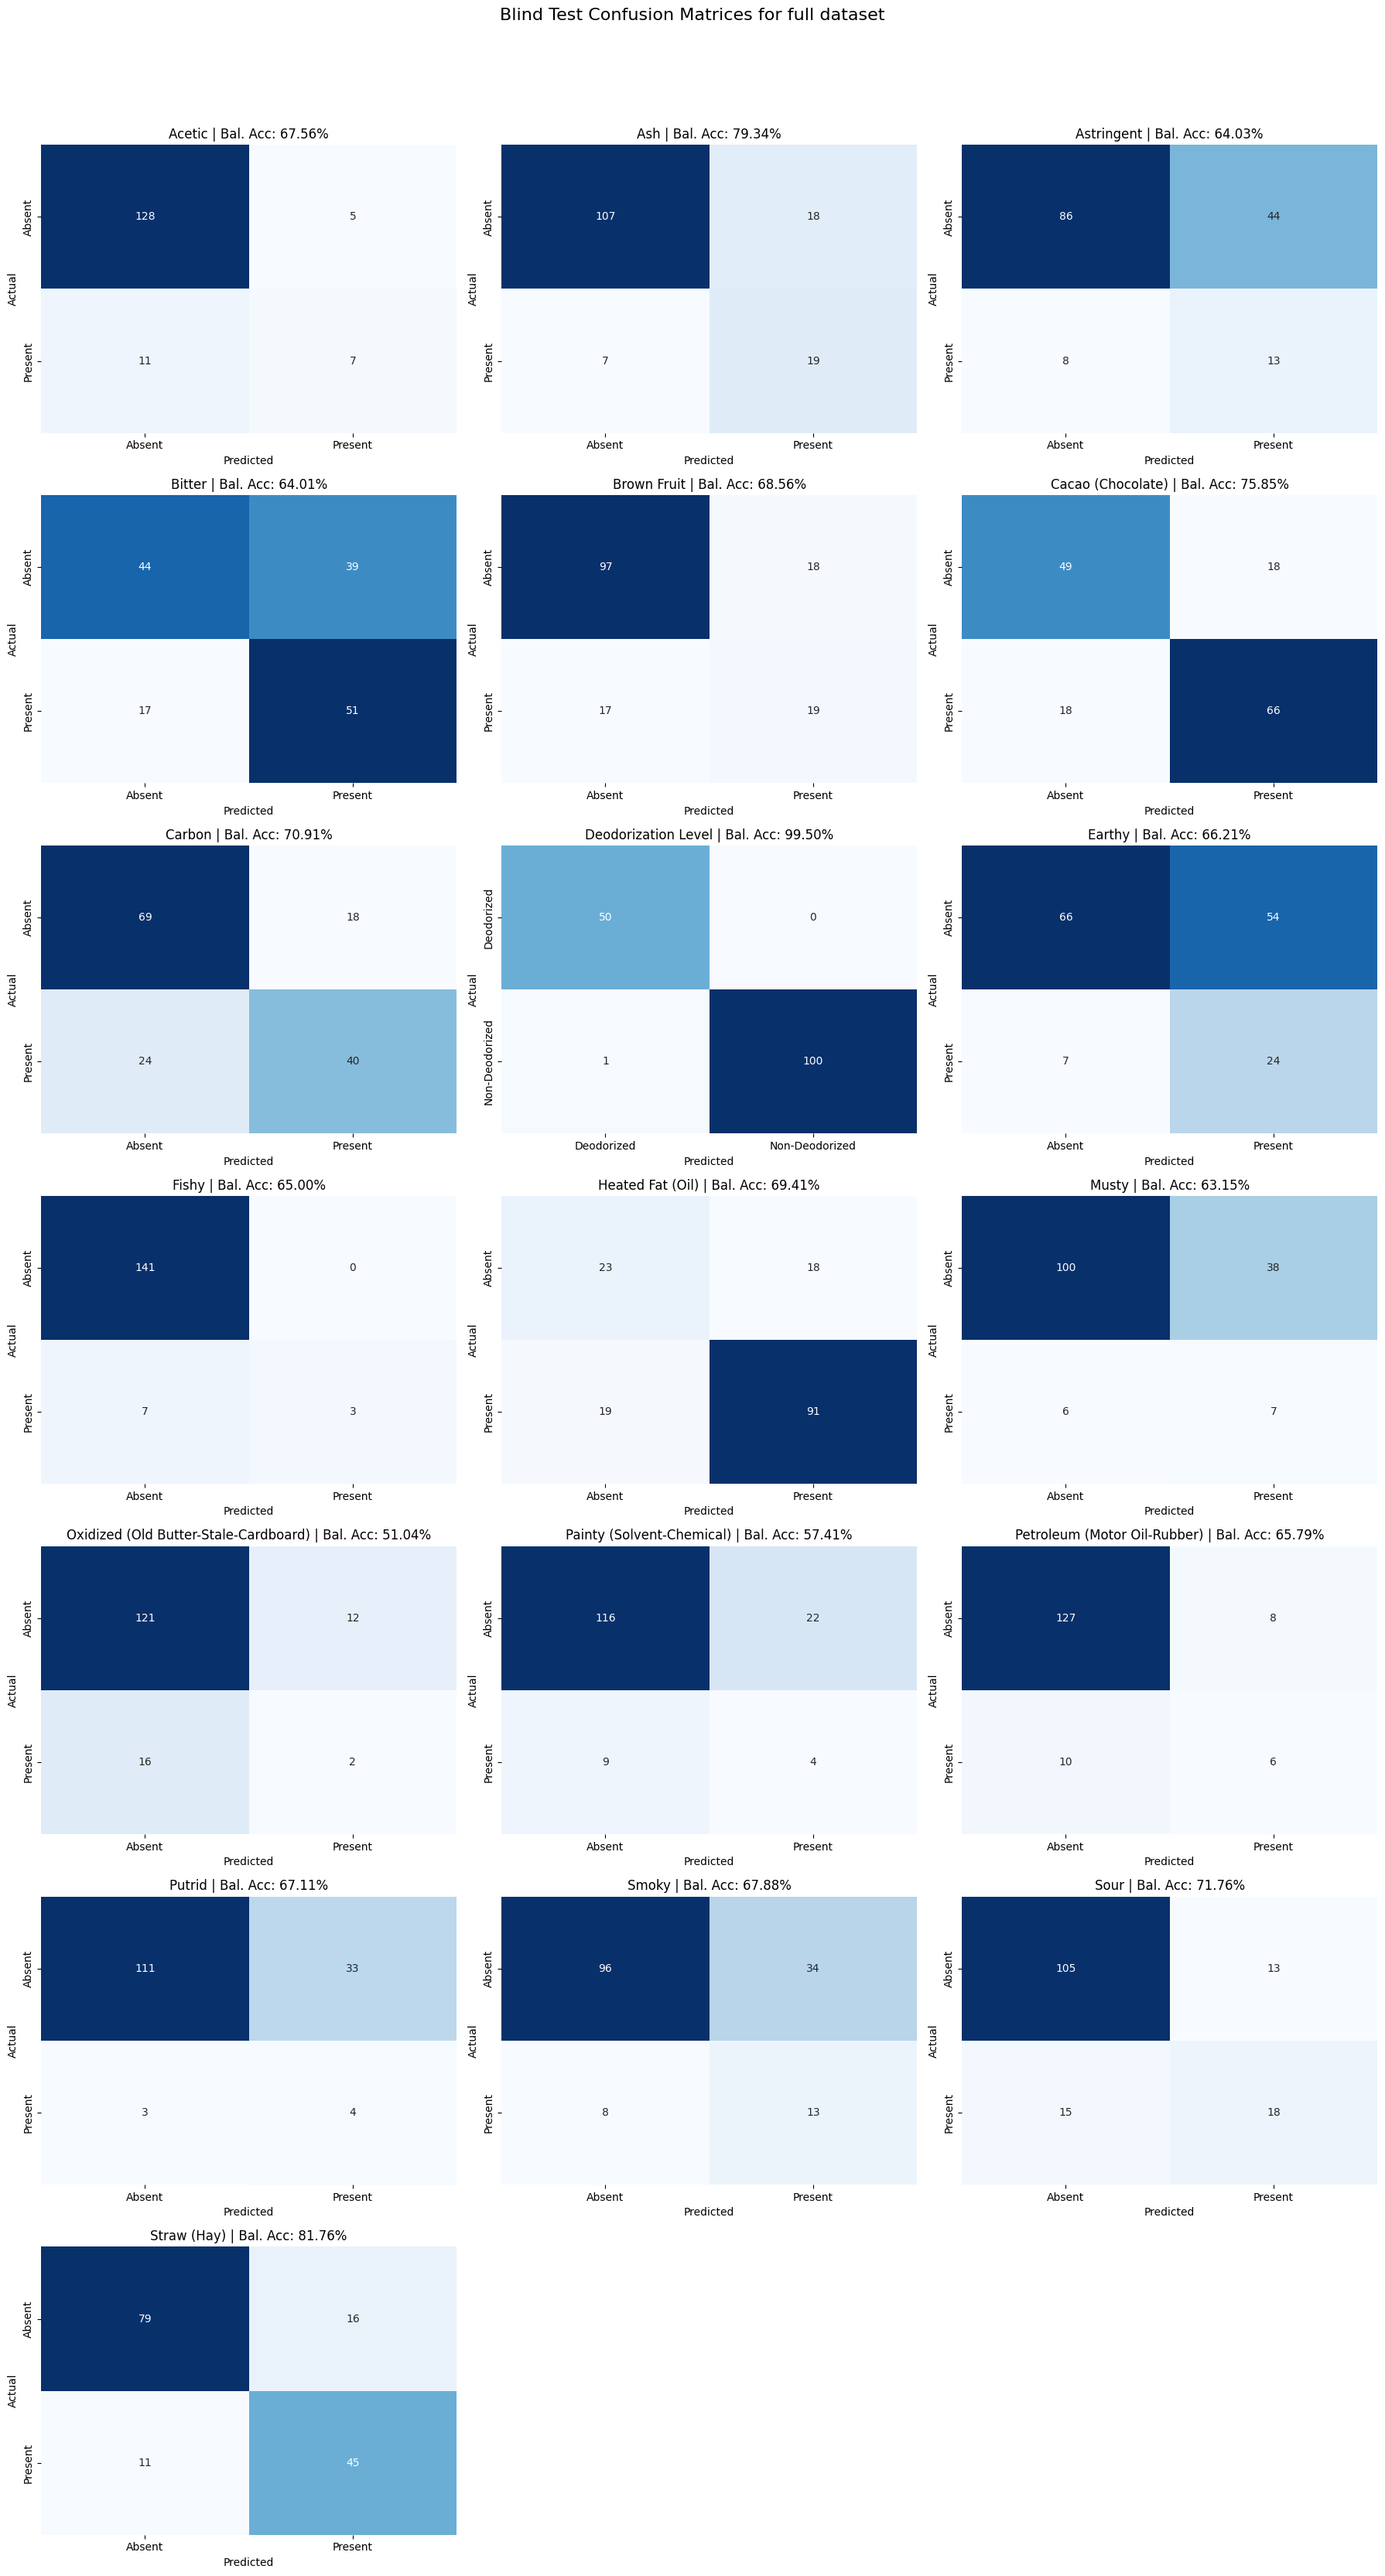

Processing nondeo dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test scores for Earthy
Getting test scores for Fishy
Getting test scores for Heated Fat (Oil)
Getting test scores for Musty
Getting test scores for Oxidized (Old Butter-Stale-Cardboard)
Getting test scores for Painty (Solvent-Chemical)
Getting test scores for Petroleum (Motor Oil-Rubber)
Getting test scores for Putrid
Getting test scores for Smoky
Getting test scores for Sour
Getting test scores for Straw (Hay)


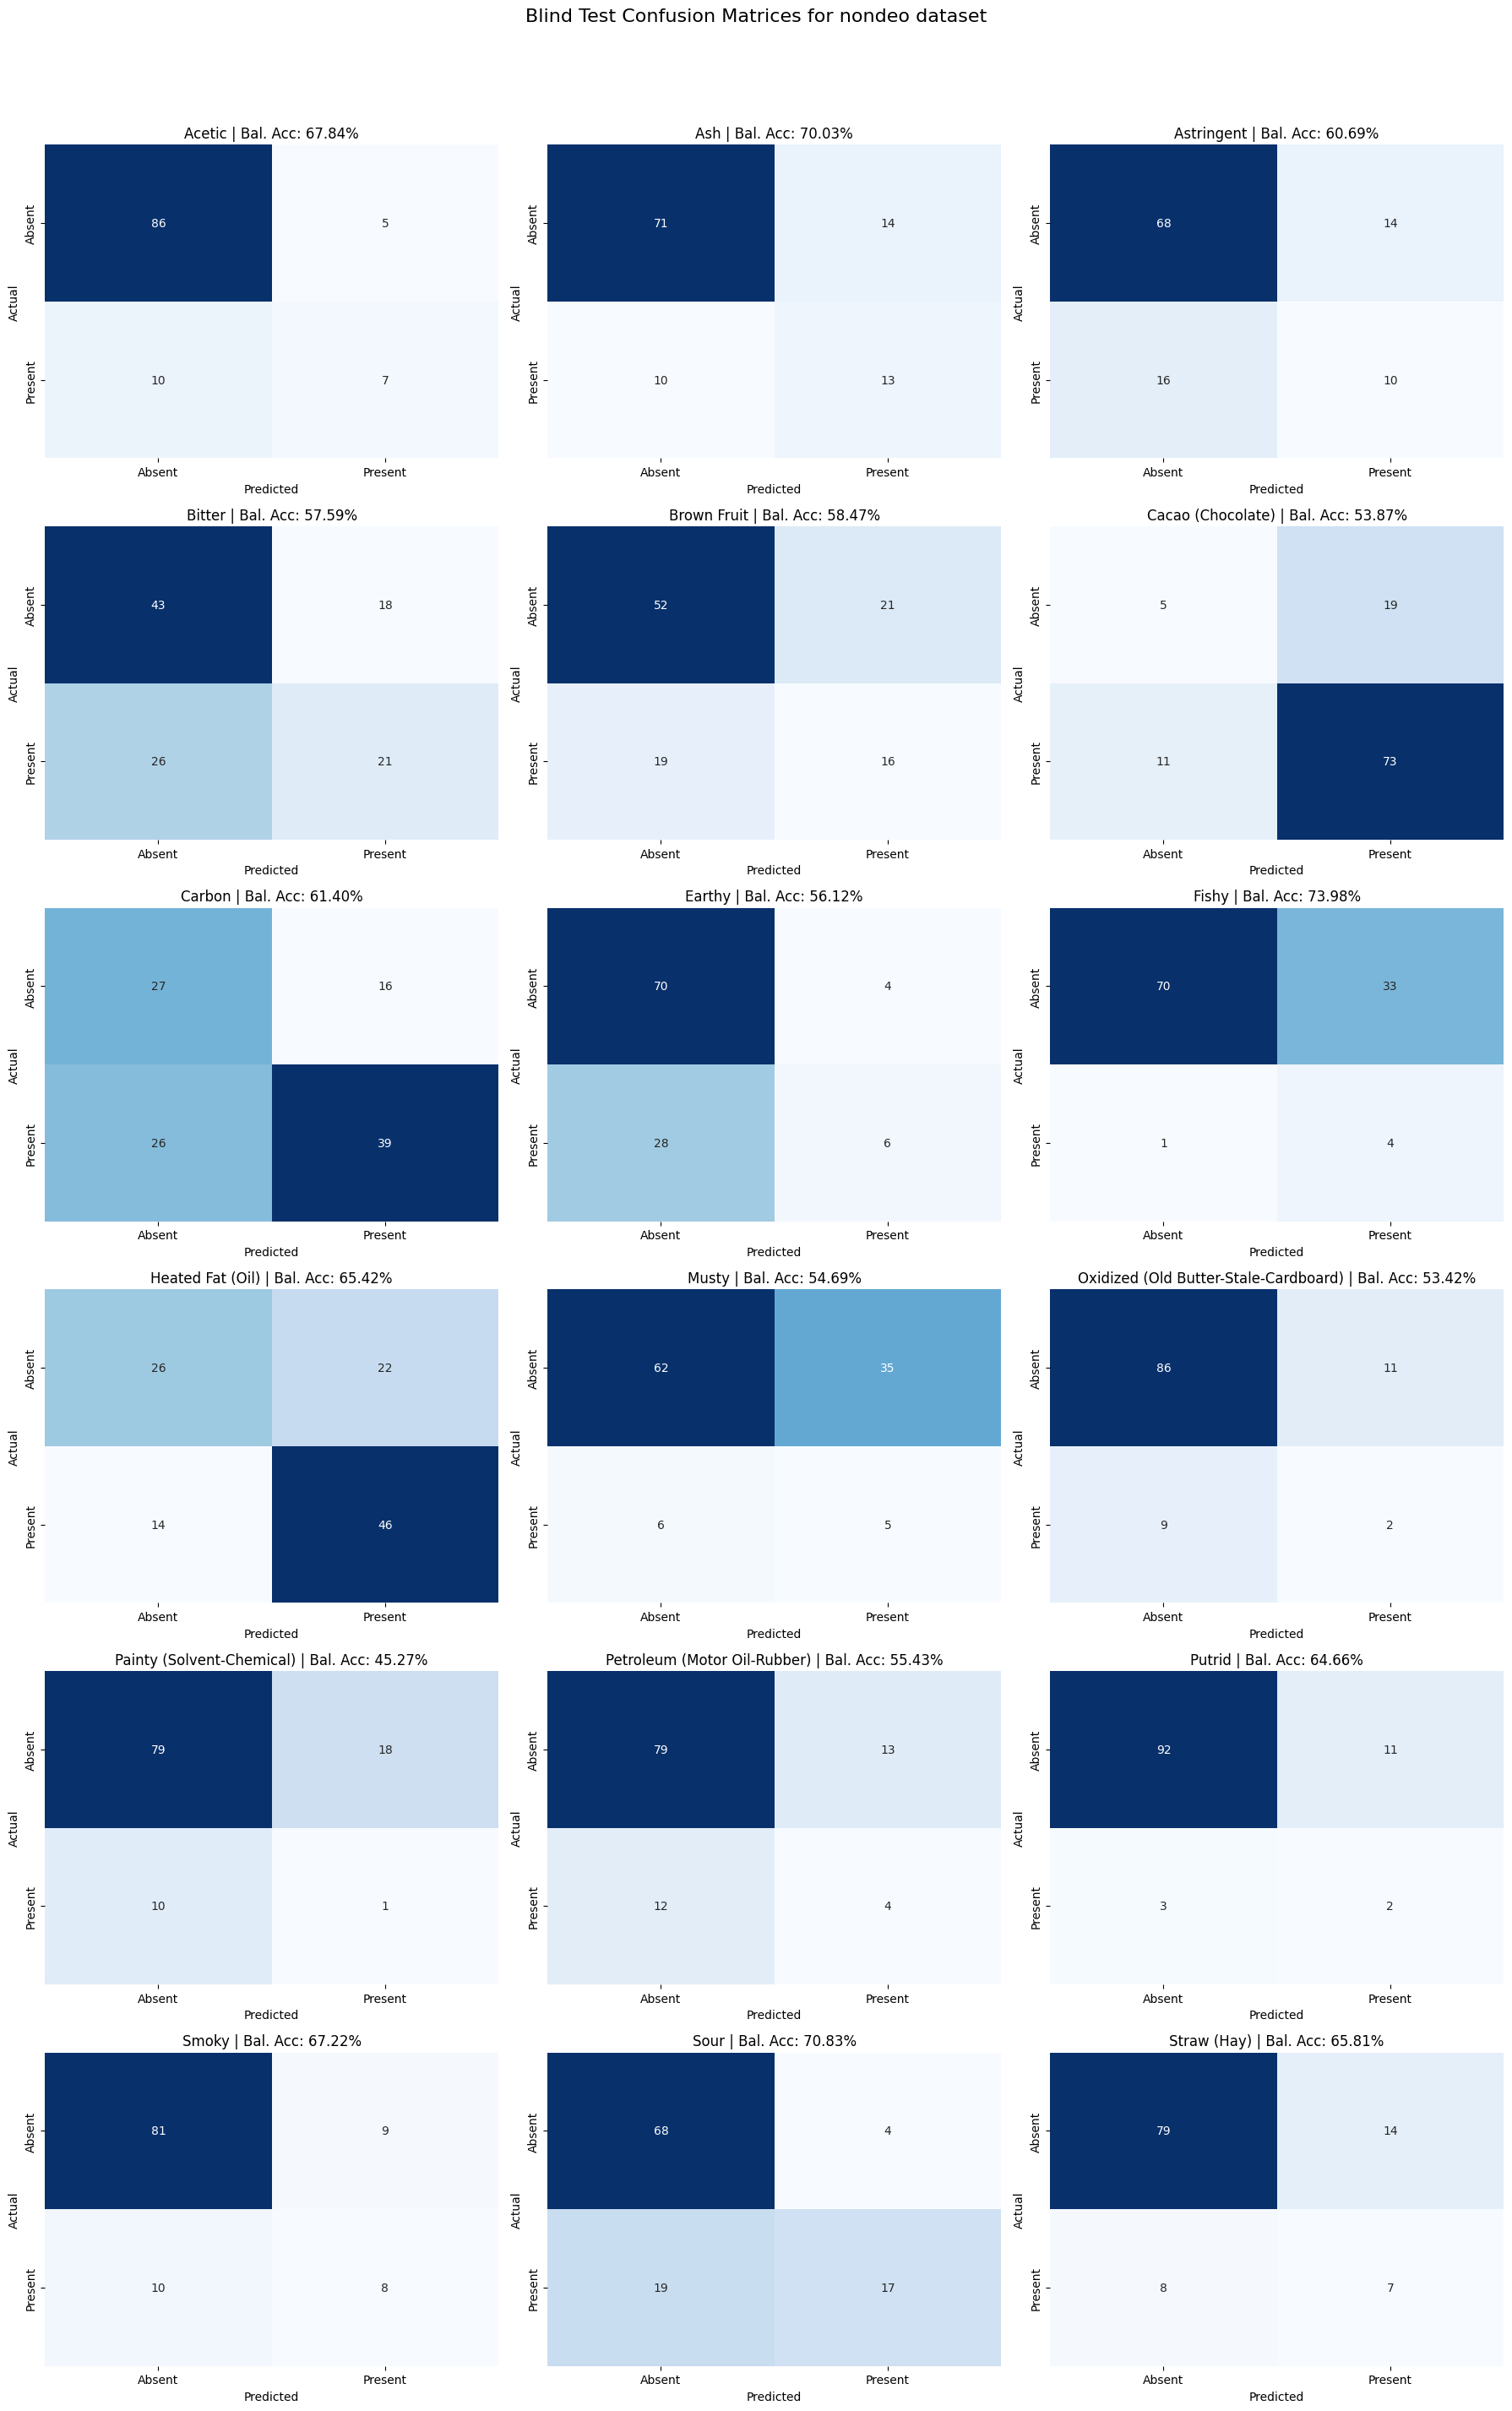

In [8]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_test = datasets[dataset]['X_test']
    y_test = datasets[dataset]['y_test']

    # Get categorical columns in y_test
    categorical_cols = [col for col in y_test.columns if y_test[col].dtype == 'object']
    num_cols = len(categorical_cols)

    # Dynamically determine subplot grid size
    ncols = min(3, num_cols)  # Max 3 columns per row
    nrows = int(np.ceil(num_cols / ncols))  # Compute required rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
    fig.suptitle(f"Blind Test Confusion Matrices for {dataset} dataset", fontsize=16)

    # Ensure axes is always a 2D array
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])  # Convert single subplot to 2D array
    elif nrows == 1:
        axes = np.array([axes])  # Convert 1D array to 2D
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])  # Convert to 2D array

    for idx, col in enumerate(categorical_cols):
        print(f'Getting test scores for {col}')
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_test = y_test[col]

        # Check if encoder exists
        encoder_path = output_dir / "encoder.pkl"
        if encoder_path.exists():
            encoder = pkl.load(open(encoder_path, "rb"))
            selected_y_test_encoded = pd.Series(
                encoder.transform(selected_y_test),
                index=selected_y_test.index
            )
        else:
            print("Encoder does not exist, skipping test")
            continue

        # Check if model exists
        model_path = output_dir / "trainer.pkl"
        if model_path.exists():
            trainer = pkl.load(open(model_path, "rb"))
        else:
            print("Model does not exist, skipping test")
            continue

        grouped_X_test = X_test.groupby(X_test.index).mean()
        grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

        # print("test")
        val_pred = trainer.predict(grouped_X_test)
        # print("test")

        cnfm = confusion_matrix(grouped_selected_y_test, val_pred)
        bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred)

        # Get subplot axes
        ax = axes[idx // ncols, idx % ncols]

        ax.set_title(f"{col} | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)

        cnfm_settings = {
            "cmap": "Blues",
            "cbar": False,
            "annot": True,
            "fmt": ".0f",
            "xticklabels": encoder.classes_,
            "yticklabels": encoder.classes_,
        }

        sns.heatmap(cnfm, ax=ax, **cnfm_settings)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide any empty subplots
    for idx in range(num_cols, nrows * ncols):  # Only affects extra subplots
        fig.delaxes(axes.flatten()[idx])  # Remove empty subplot
        
    # Adjust layout and save the combined figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"../models/automl/{dataset}/blinds_metrics_summary.png", bbox_inches="tight")
    plt.show()
    plt.close()


## summarised cfm downsampled

Processing full dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test scores for Deodorization Level
Getting test scores for Earthy
Getting test scores for Fishy
Getting test scores for Heated Fat (Oil)
Getting test scores for Musty
Getting test scores for Oxidized (Old Butter-Stale-Cardboard)
Getting test scores for Painty (Solvent-Chemical)
Getting test scores for Petroleum (Motor Oil-Rubber)
Getting test scores for Putrid
Getting test scores for Smoky
Getting test scores for Sour
Getting test scores for Straw (Hay)


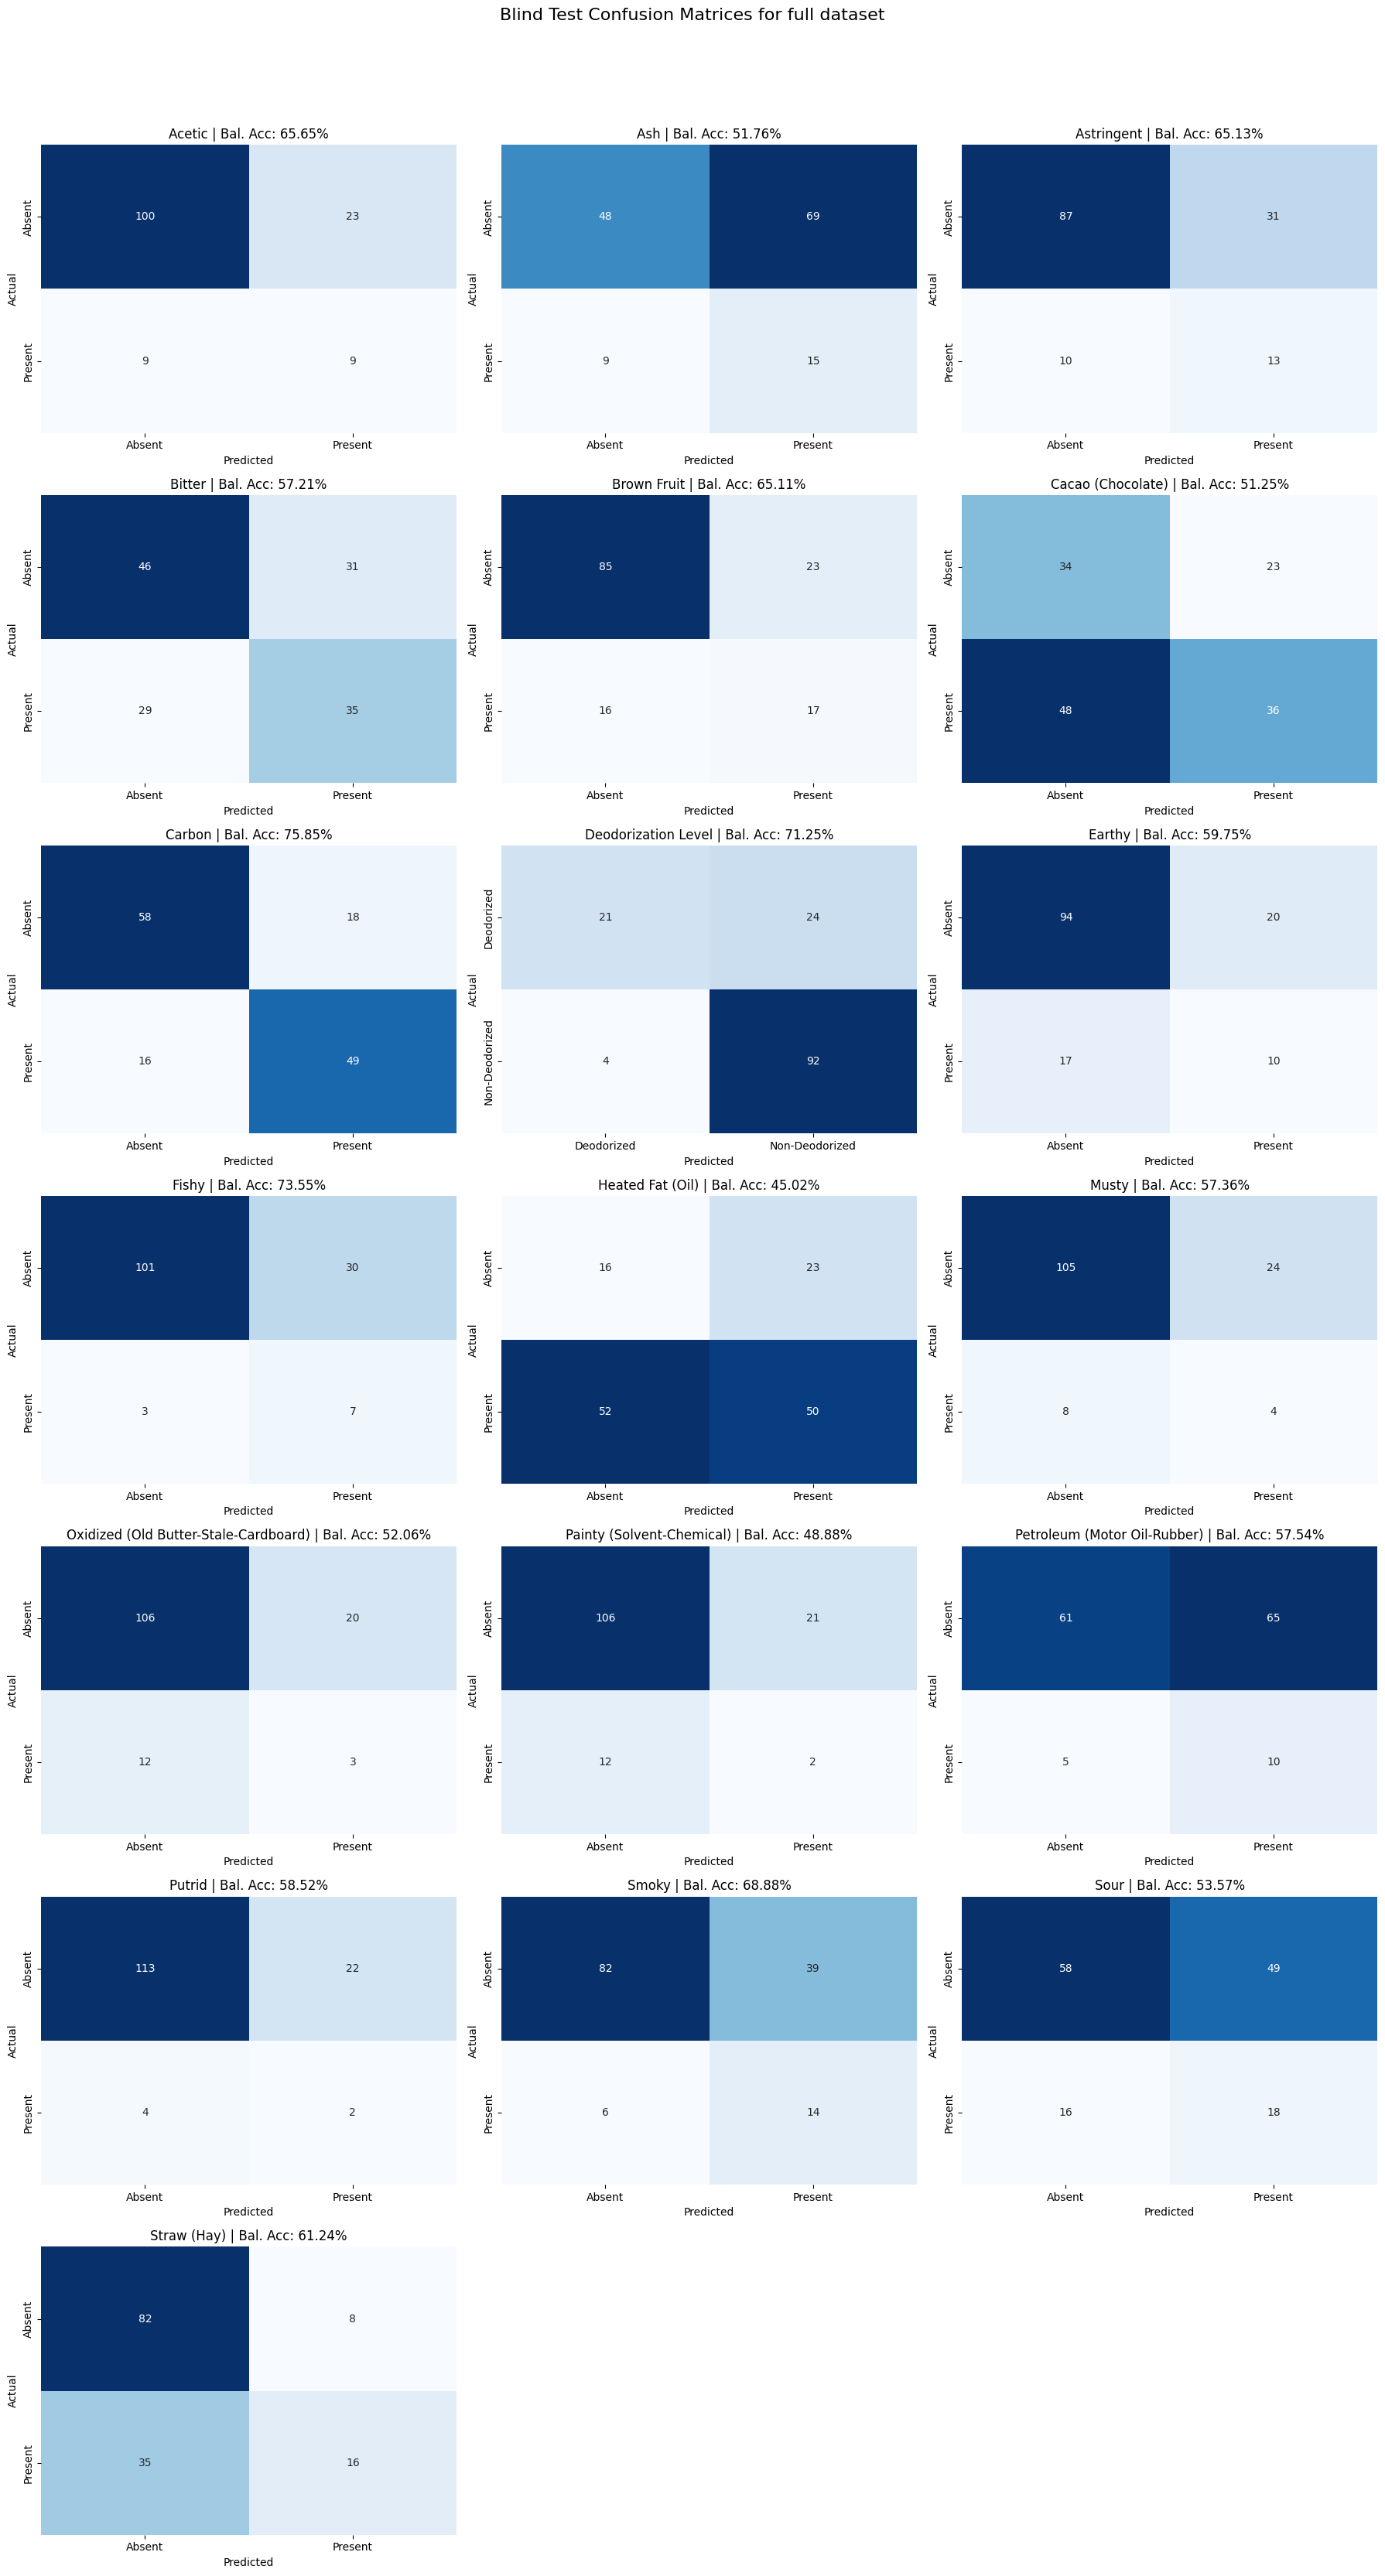

Processing nondeo dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test scores for Earthy
Getting test scores for Fishy
Getting test scores for Heated Fat (Oil)
Getting test scores for Musty
Getting test scores for Oxidized (Old Butter-Stale-Cardboard)
Getting test scores for Painty (Solvent-Chemical)
Getting test scores for Petroleum (Motor Oil-Rubber)
Getting test scores for Putrid
Getting test scores for Smoky
Getting test scores for Sour
Getting test scores for Straw (Hay)


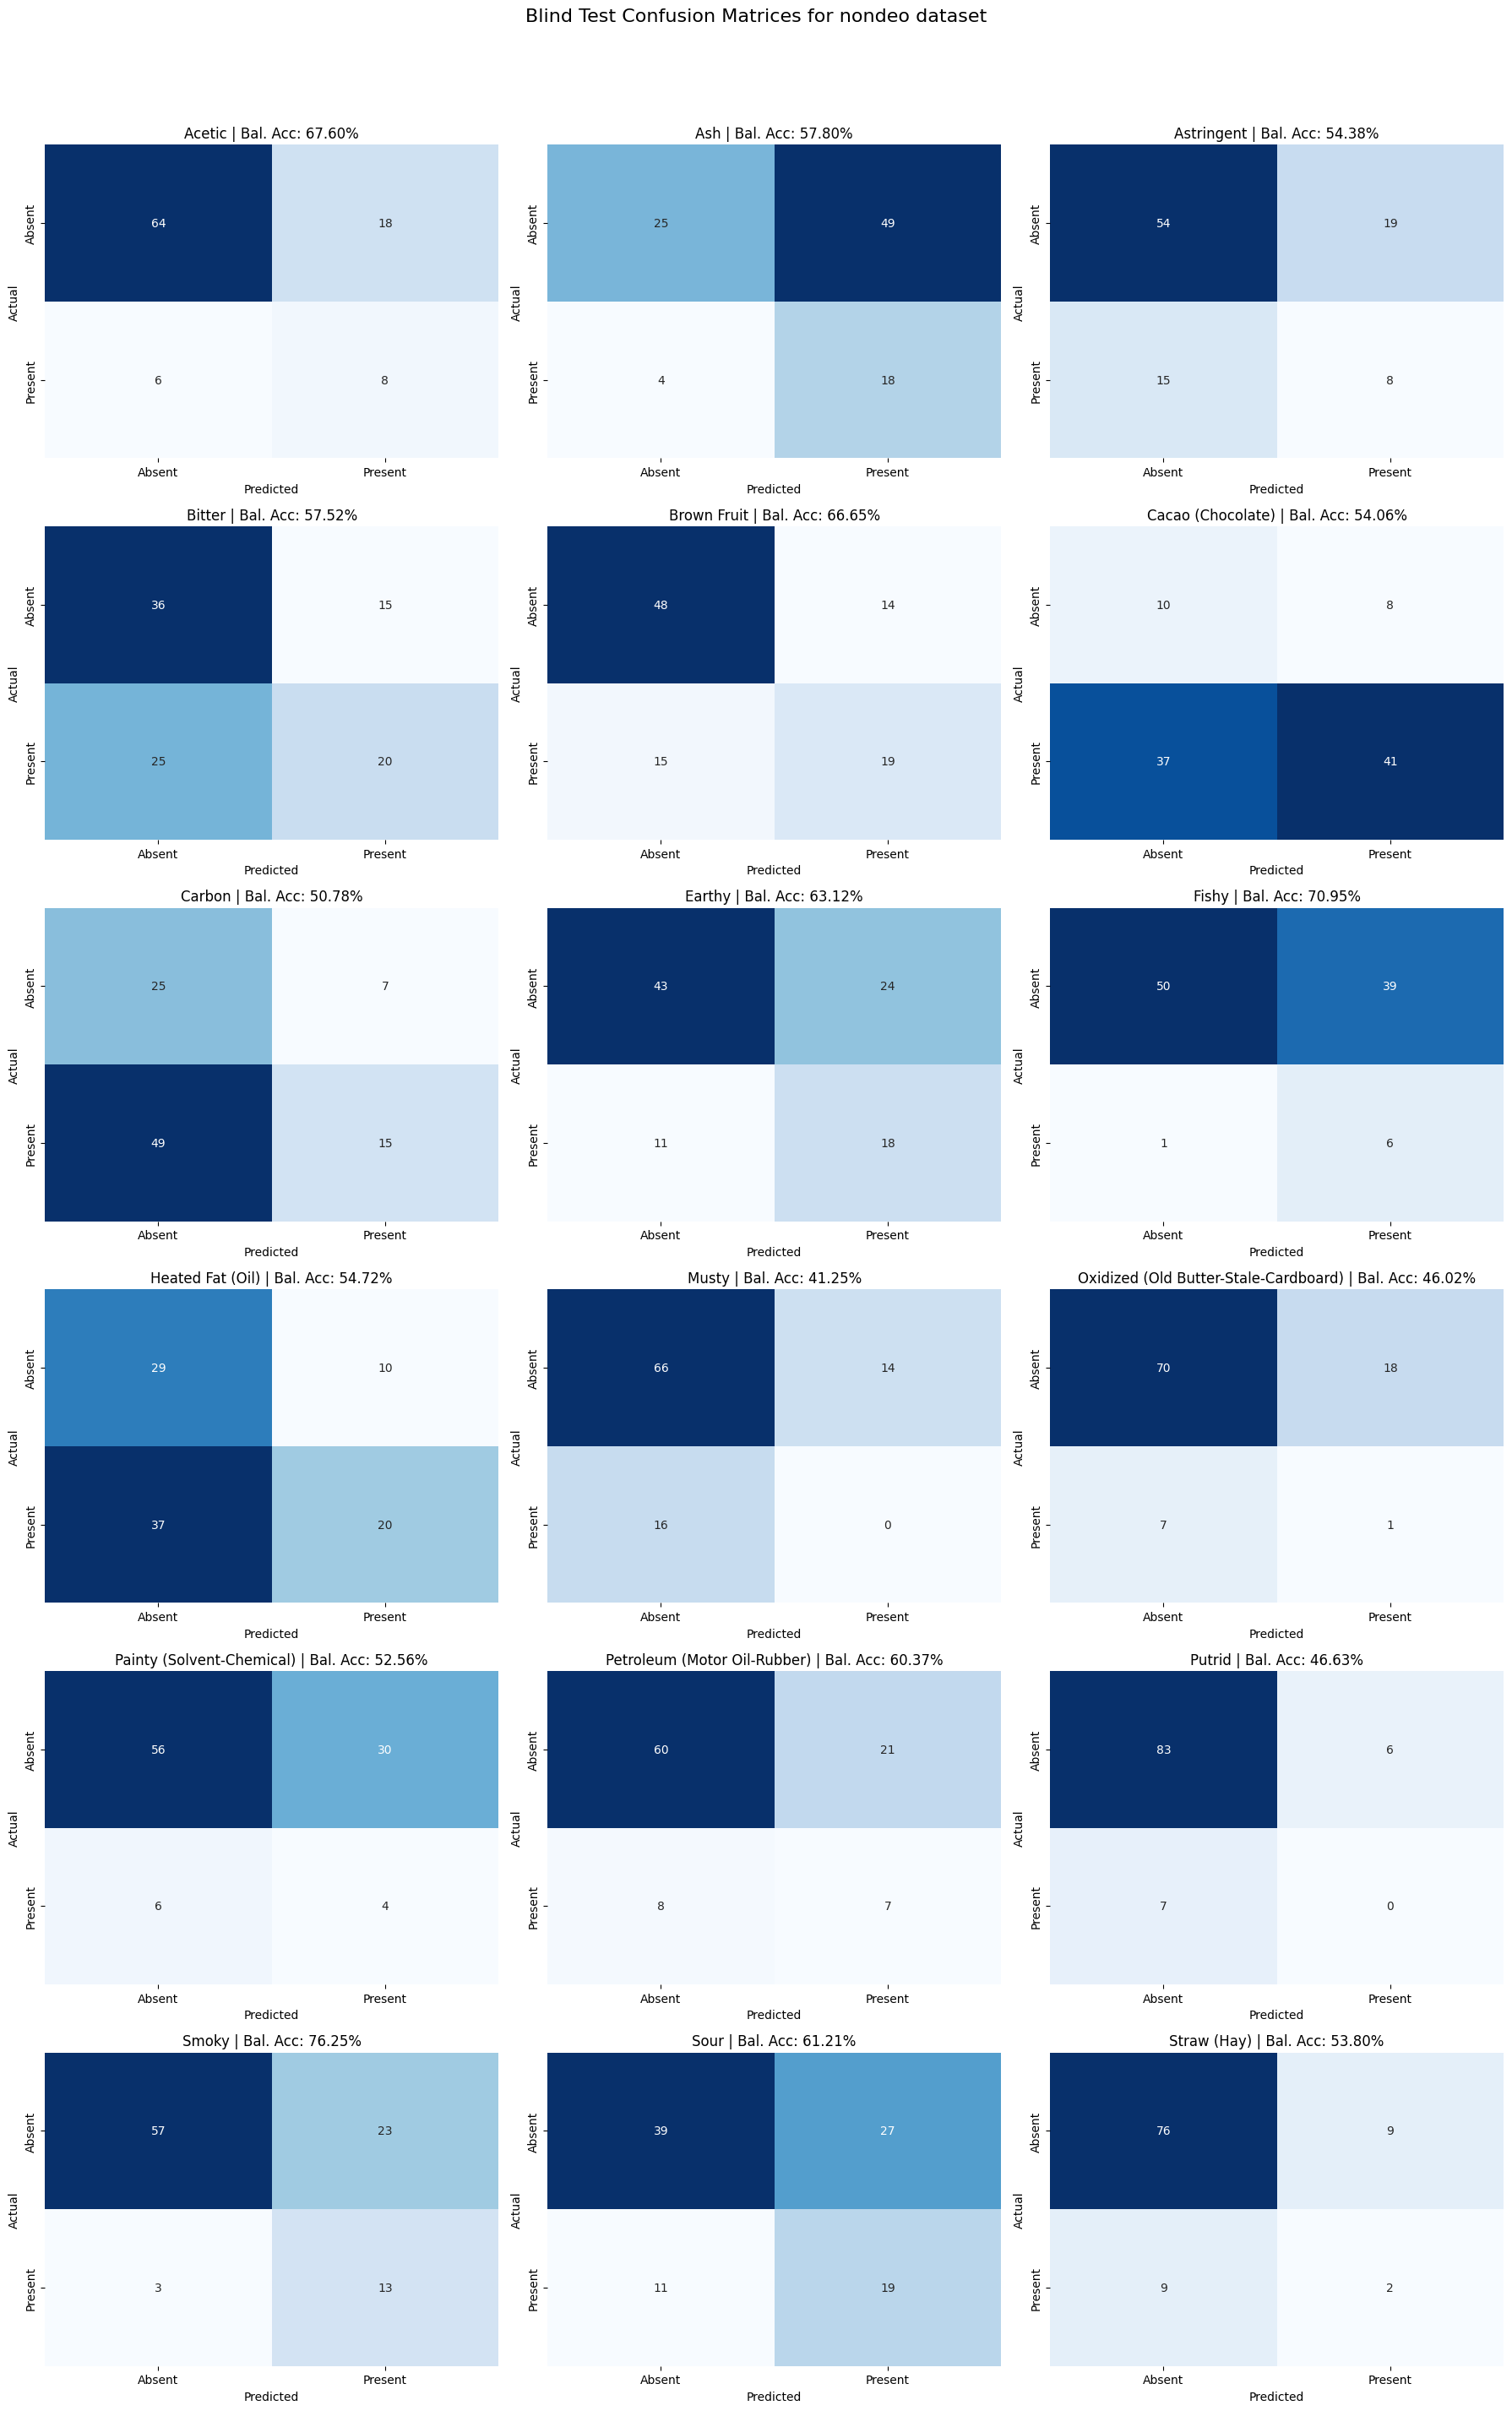

In [ ]:
# for dataset in datasets:
#     print(f'Processing {dataset} dataset')
#     X_test = datasets[dataset]['X_test']
#     y_test = datasets[dataset]['y_test']

#     # Get categorical columns in y_test
#     categorical_cols = [col for col in y_test.columns if y_test[col].dtype == 'object']
#     num_cols = len(categorical_cols)

#     # Dynamically determine subplot grid size
#     ncols = min(3, num_cols)  # Max 3 columns per row
#     nrows = int(np.ceil(num_cols / ncols))  # Compute required rows

#     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
#     fig.suptitle(f"Blind Test Confusion Matrices for {dataset} dataset", fontsize=16)

#     # Ensure axes is always a 2D array
#     if nrows == 1 and ncols == 1:
#         axes = np.array([[axes]])  # Convert single subplot to 2D array
#     elif nrows == 1:
#         axes = np.array([axes])  # Convert 1D array to 2D
#     elif ncols == 1:
#         axes = np.array([[ax] for ax in axes])  # Convert to 2D array

#     for idx, col in enumerate(categorical_cols):
#         print(f'Getting test scores for {col}')
        
#         output_dir = Path(f"../models/automl/{dataset}_downsampled/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_test = y_test[col]

#         # Check if encoder exists
#         encoder_path = output_dir / "encoder.pkl"
#         if encoder_path.exists():
#             encoder = pkl.load(open(encoder_path, "rb"))
#             selected_y_test_encoded = pd.Series(
#                 encoder.transform(selected_y_test),
#                 index=selected_y_test.index
#             )
#         else:
#             print("Encoder does not exist, skipping test")
#             continue

#         # Check if model exists
#         model_path = output_dir / "trainer.pkl"
#         if model_path.exists():
#             trainer = pkl.load(open(model_path, "rb"))
#         else:
#             print("Model does not exist, skipping test")
#             continue

#         grouped_X_test = X_test.groupby(X_test.index).mean()
#         grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

#         # print("test")
#         val_pred = trainer.predict(grouped_X_test)
#         # print("test")

#         cnfm = confusion_matrix(grouped_selected_y_test, val_pred)
#         bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred)

#         # Get subplot axes
#         ax = axes[idx // ncols, idx % ncols]

#         ax.set_title(f"{col} | Bal. Acc: {bal_acc*100:.2f}%", fontsize=12)

#         cnfm_settings = {
#             "cmap": "Blues",
#             "cbar": False,
#             "annot": True,
#             "fmt": ".0f",
#             "xticklabels": encoder.classes_,
#             "yticklabels": encoder.classes_,
#         }

#         sns.heatmap(cnfm, ax=ax, **cnfm_settings)
#         ax.set_xlabel("Predicted")
#         ax.set_ylabel("Actual")

#     # Hide any empty subplots
#     for idx in range(num_cols, nrows * ncols):  # Only affects extra subplots
#         fig.delaxes(axes.flatten()[idx])  # Remove empty subplot
        
#     # Adjust layout and save the combined figure
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig(f"../models/automl/{dataset}_downsampled/blinds_metrics_summary.png", bbox_inches="tight")
#     plt.show()
#     plt.close()


## individual cfm

In [10]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    X_test = datasets[dataset]['X_test']
    y_test = datasets[dataset]['y_test']

    for col in y_test.columns:
        if y_test[col].dtype != 'object':
            continue
        print(f'Getting test scores for {col}')
        
        output_dir = Path(f"../models/automl/{dataset}/{col}")
        output_dir.mkdir(parents=True, exist_ok=True)
        selected_y_test = y_test[col]

        #check if encoder exists
        if (output_dir / "encoder.pkl").exists():
            encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
            selected_y_test_encoded = pd.Series(
                encoder.transform(selected_y_test),
                index = selected_y_test.index
            )
        else:
            print("Encoder does not exist, skipping test")

        # check if model exists
        if (output_dir / "trainer.pkl").exists():
            trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
        else:
            print("Model does not exist, skipping test")

        grouped_X_test = X_test.groupby(X_test.index).mean()
        grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

        val_pred = trainer.predict(grouped_X_test)

        cnfm = confusion_matrix(grouped_selected_y_test, val_pred)
        bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred)

        fig = plt.figure(figsize = (6, 4))
        fig.suptitle(f"{col} | Blinds")
        ax = fig.add_subplot(111)

        ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

        cnfm_settings = {
            "cmap": "Blues",
            "cbar": None,
            "annot": True,
            "fmt": ".0f",
            "xticklabels": encoder.classes_,
            "yticklabels": encoder.classes_,
        }

        sns.heatmap(
            cnfm,
            ax = ax,
            **cnfm_settings
        )

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        # plt.tight_layout()
        plt.savefig(output_dir / "blinds_metrics.png", bbox_inches = "tight")
        # plt.show()
        plt.close()

Processing full dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test scores for Deodorization Level
Getting test scores for Earthy
Getting test scores for Fishy
Getting test scores for Heated Fat (Oil)
Getting test scores for Musty
Getting test scores for Oxidized (Old Butter-Stale-Cardboard)
Getting test scores for Painty (Solvent-Chemical)
Getting test scores for Petroleum (Motor Oil-Rubber)
Getting test scores for Putrid
Getting test scores for Smoky
Getting test scores for Sour
Getting test scores for Straw (Hay)
Processing nondeo dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test sc

## indivdual cfm downsampled

In [ ]:
# for dataset in datasets:
#     print(f'Processing {dataset} dataset')
#     X_test = datasets[dataset]['X_test']
#     y_test = datasets[dataset]['y_test']

#     for col in y_test.columns:
#         if y_test[col].dtype != 'object':
#             continue
#         print(f'Getting test scores for {col}')
        
#         output_dir = Path(f"../models/automl/{dataset}_downsampled/{col}")
#         output_dir.mkdir(parents=True, exist_ok=True)
#         selected_y_test = y_test[col]

#         #check if encoder exists
#         if (output_dir / "encoder.pkl").exists():
#             encoder = pkl.load(open(output_dir / "encoder.pkl", "rb"))
#             selected_y_test_encoded = pd.Series(
#                 encoder.transform(selected_y_test),
#                 index = selected_y_test.index
#             )
#         else:
#             print("Encoder does not exist, skipping test")

#         # check if model exists
#         if (output_dir / "trainer.pkl").exists():
#             trainer = pkl.load(open(output_dir / "trainer.pkl", "rb"))
#         else:
#             print("Model does not exist, skipping test")

#         grouped_X_test = X_test.groupby(X_test.index).mean()
#         grouped_selected_y_test = selected_y_test_encoded.groupby(selected_y_test_encoded.index).mean()

#         val_pred = trainer.predict(grouped_X_test)

#         cnfm = confusion_matrix(grouped_selected_y_test, val_pred)
#         bal_acc = balanced_accuracy_score(grouped_selected_y_test, val_pred)

#         fig = plt.figure(figsize = (6, 4))
#         fig.suptitle(f"{col} | Blinds")
#         ax = fig.add_subplot(111)

#         ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

#         cnfm_settings = {
#             "cmap": "Blues",
#             "cbar": None,
#             "annot": True,
#             "fmt": ".0f",
#             "xticklabels": encoder.classes_,
#             "yticklabels": encoder.classes_,
#         }

#         sns.heatmap(
#             cnfm,
#             ax = ax,
#             **cnfm_settings
#         )

#         ax.set_xlabel('Predicted')
#         ax.set_ylabel('Actual')

#         # plt.tight_layout()
#         plt.savefig(output_dir / "blinds_metrics.png", bbox_inches = "tight")
#         # plt.show()
#         plt.close()

Processing full dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test scores for Deodorization Level
Getting test scores for Earthy
Getting test scores for Fishy
Getting test scores for Heated Fat (Oil)
Getting test scores for Musty
Getting test scores for Oxidized (Old Butter-Stale-Cardboard)
Getting test scores for Painty (Solvent-Chemical)
Getting test scores for Petroleum (Motor Oil-Rubber)
Getting test scores for Putrid
Getting test scores for Smoky
Getting test scores for Sour
Getting test scores for Straw (Hay)
Processing nondeo dataset
Getting test scores for Acetic
Getting test scores for Ash
Getting test scores for Astringent
Getting test scores for Bitter
Getting test scores for Brown Fruit
Getting test scores for Cacao (Chocolate)
Getting test scores for Carbon
Getting test sc